#### biochemistry summary

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#%%
def plot_multi(data=[[11,50,37,202,7],[47,19,195,117,74],[136,69,33,47],[100,12,25,139,89]],names = ["+PBS","+Nefopam","+Ketoprofen","+Cefotaxime"],value="ALT (U/I)",title="",dpi=100,log_scale=False):
    tmp_color = sns.color_palette("tab10")
    sns.set_style('whitegrid')
        
    fig,ax = plt.subplots(dpi=dpi)
    sns.color_palette("tab10")
    df = pd.DataFrame()
    for i in range(len(data)):
        tmp_df = pd.DataFrame({names[i]:data[i]})
        df = pd.concat([df,tmp_df],axis=1)
    error_bar_set = dict(lw=1,capthick=1,capsize=50/(len(data)-1))
    if log_scale:    
        ax.set_yscale('log')
    ax.bar([i for i in range(len(data))],df.mean(),yerr=df.std(),tick_label=df.columns,error_kw=error_bar_set,color=tmp_color)
    # jitter plot
    df_melt = pd.melt(df)
    sns.stripplot(x='variable', y='value', size=4, data=df_melt, jitter=True, color='black', ax = ax)
        
    ax.set_xlabel('')
    ax.set_ylabel(value)
    plt.title(title)
    plt.xticks(rotation=60)
    plt.show()


***
##### ALT, AST and TBIL

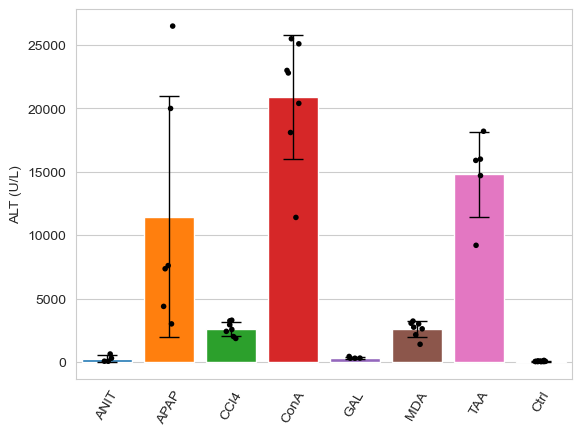

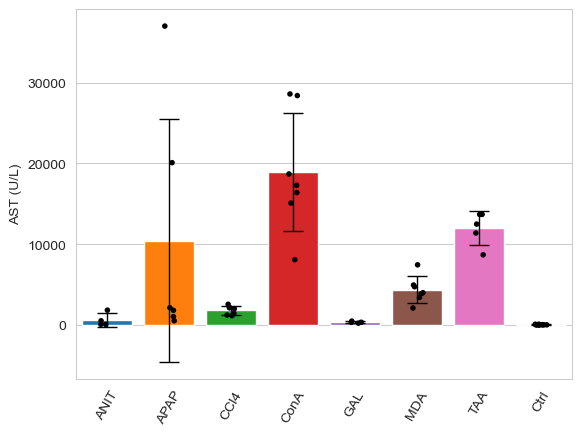

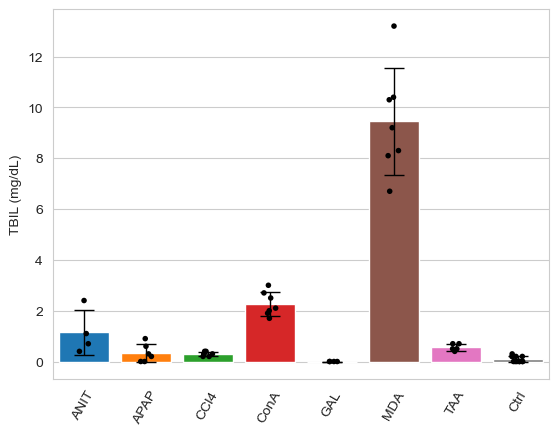

In [3]:
#%% blood biochemistry values by treatment group
df = pd.read_csv('C:/github/LiverDeconv/Data/processed/mix_processed.csv',index_col=0)
samples = df.columns.tolist()

bb_df = pd.read_csv('C:/github/LiverDeconv/Data/input/blood_biochemistry_values.csv',index_col=0)

# ALT
comp_list = ['ANIT', 'APAP', 'CCl4', 'ConA', 'GAL', 'MDA', 'TAA', 'Ctrl']
bb_values = []
for comp in comp_list:
    tmp_df = bb_df[bb_df['Treatment']==comp]
    bb_values.append(tmp_df['ALT'].tolist())
plot_multi(data=bb_values,names=comp_list,value="ALT (U/L)",log_scale=False)

# AST
comp_list = ['ANIT', 'APAP', 'CCl4', 'ConA', 'GAL', 'MDA', 'TAA', 'Ctrl']
bb_values = []
for comp in comp_list:
    tmp_df = bb_df[bb_df['Treatment']==comp]
    bb_values.append(tmp_df['AST'].tolist())
plot_multi(data=bb_values,names=comp_list,value="AST (U/L)",log_scale=False)

# TBIL
comp_list = ['ANIT', 'APAP', 'CCl4', 'ConA', 'GAL', 'MDA', 'TAA', 'Ctrl']
bb_values = []
for comp in comp_list:
    tmp_df = bb_df[bb_df['Treatment']==comp]
    bb_values.append(tmp_df['TBIL'].tolist())
plot_multi(data=bb_values,names=comp_list,value="TBIL (mg/dL)",log_scale=False)

***
##### Blood biochemistry value and immune response

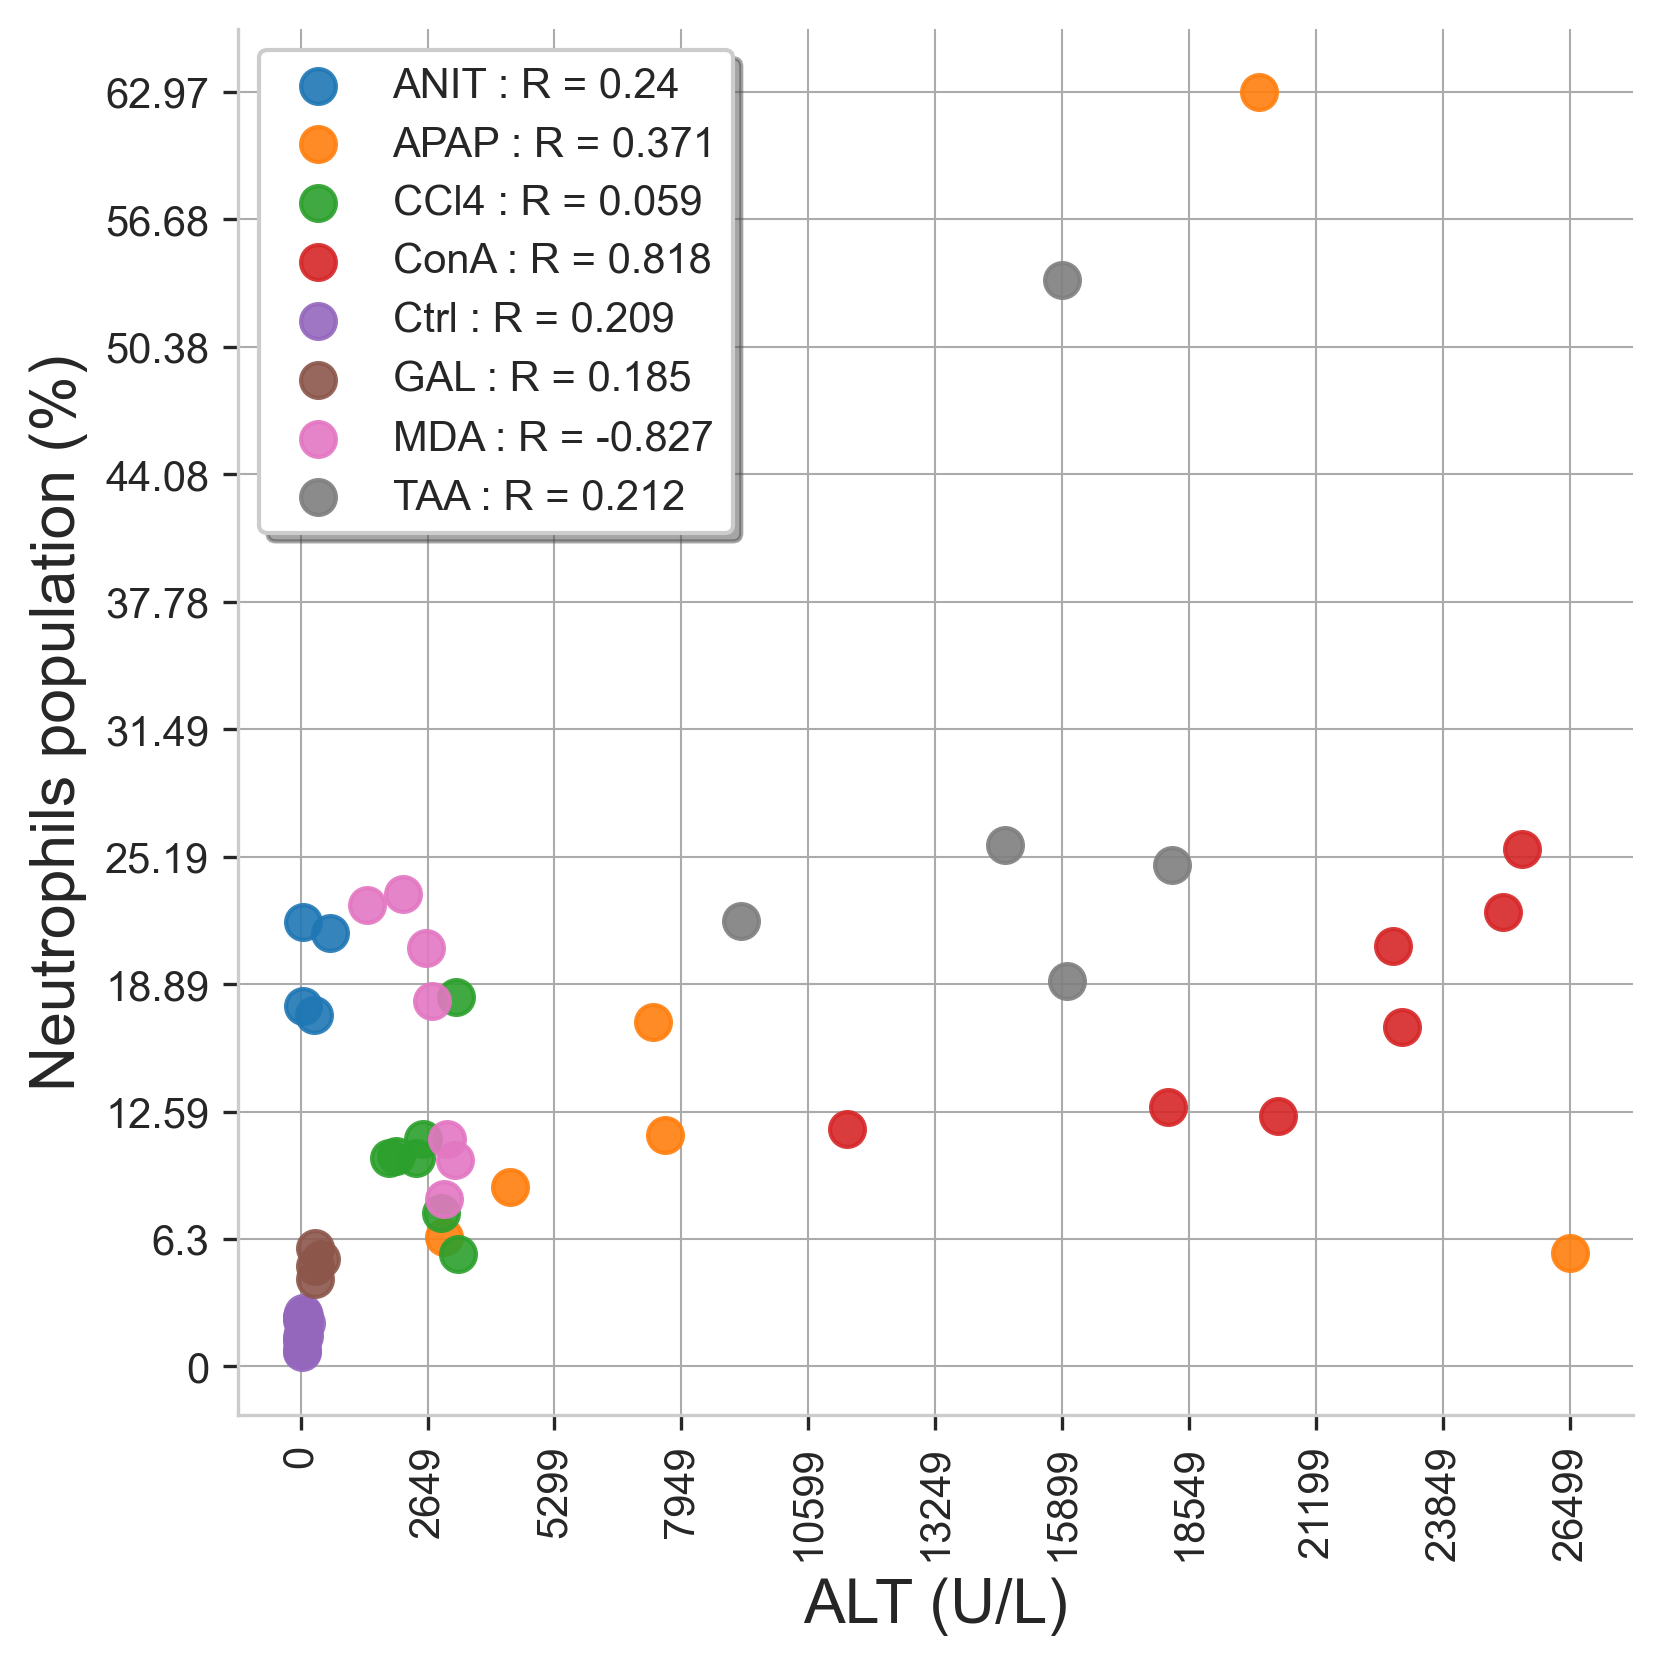

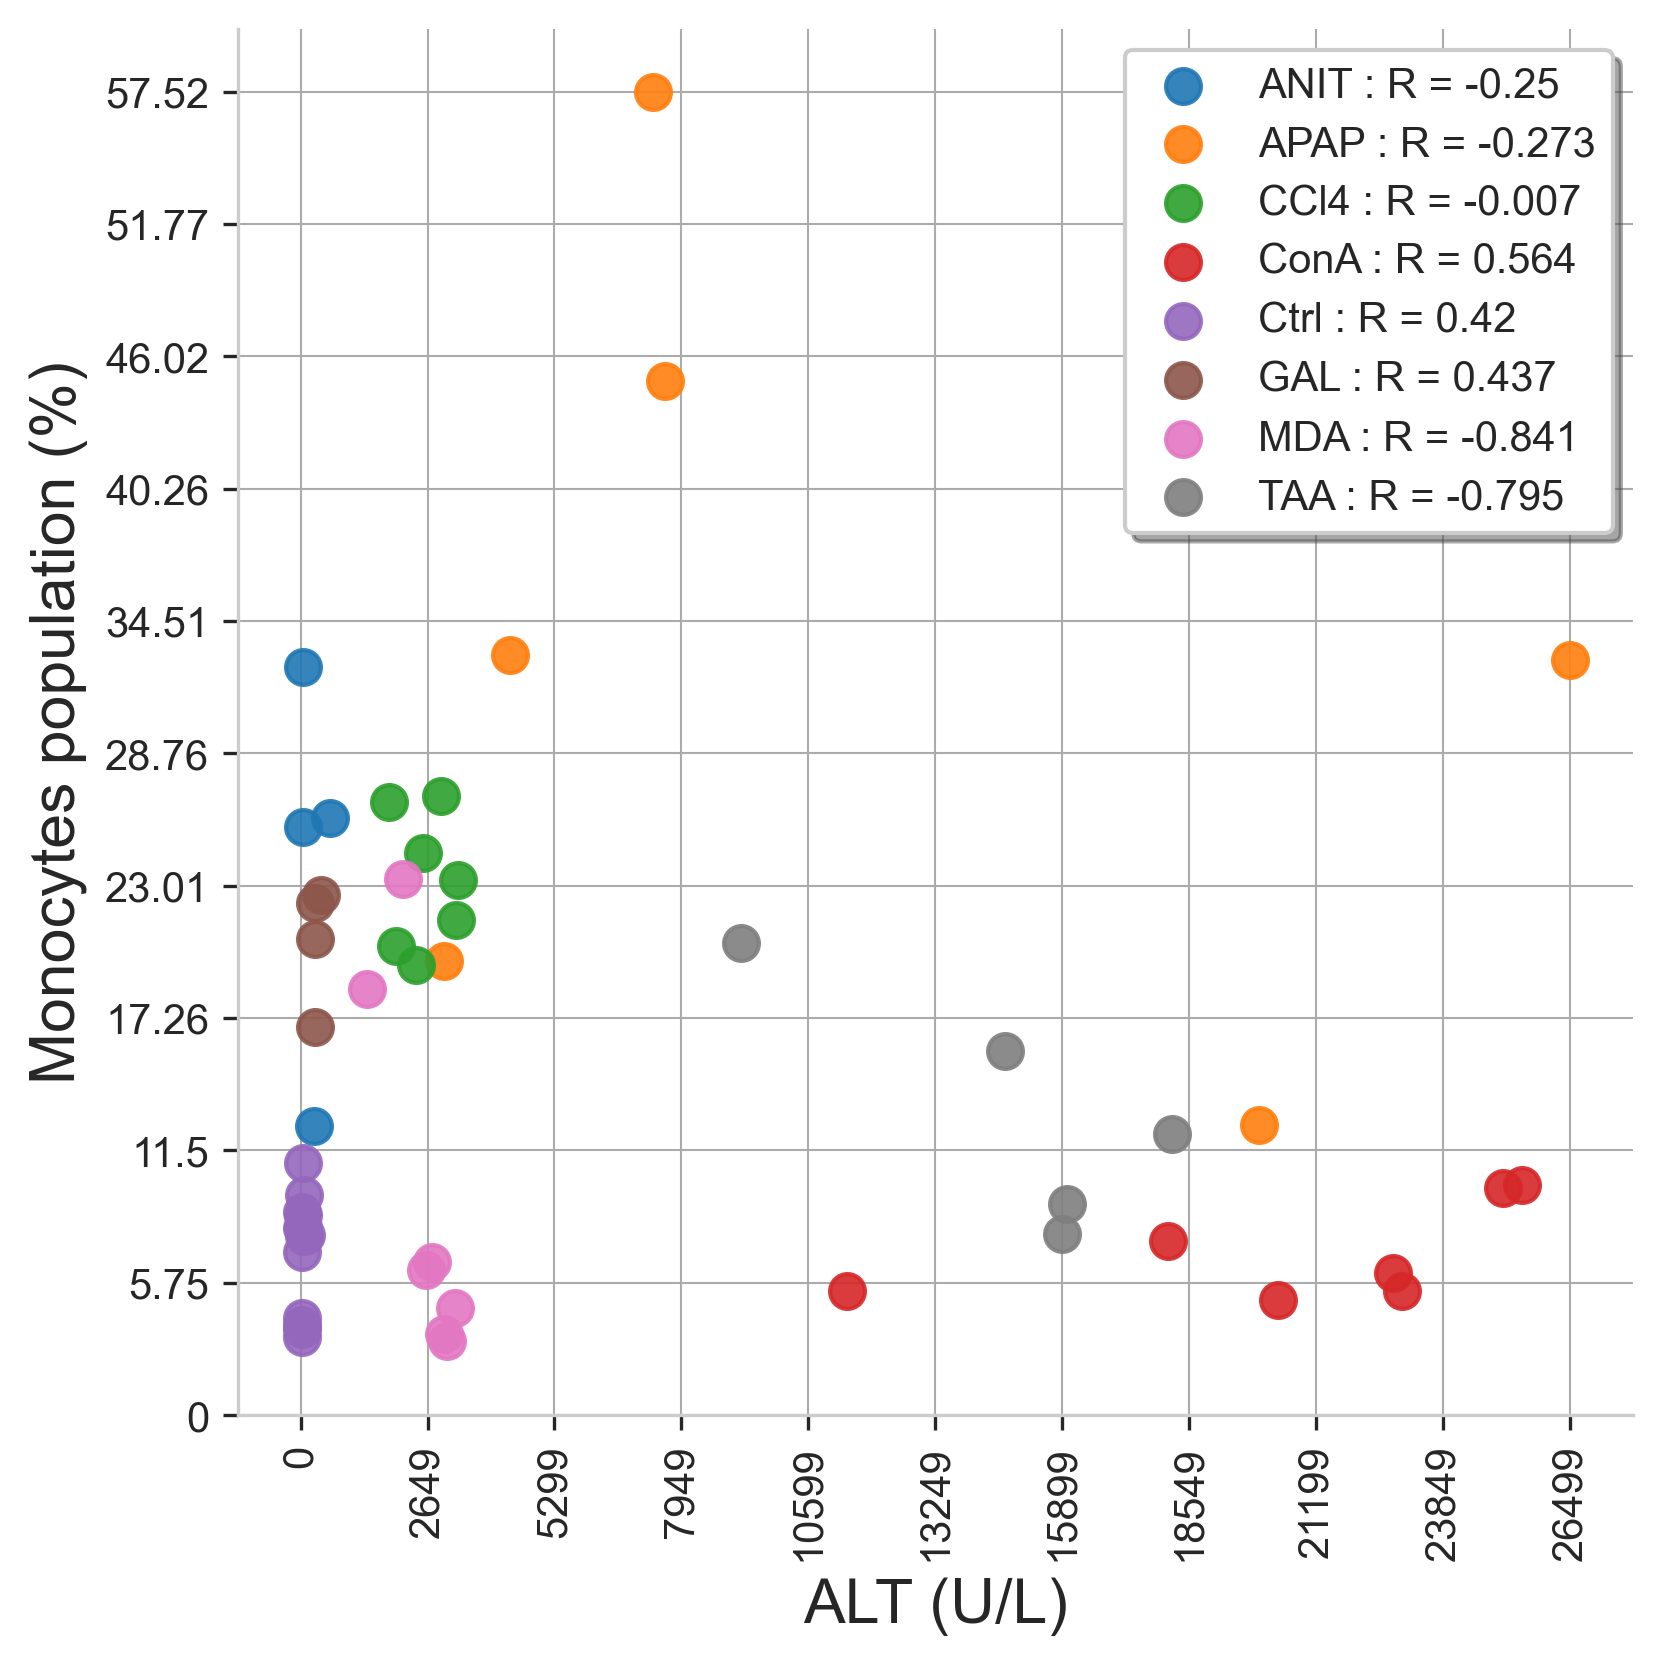

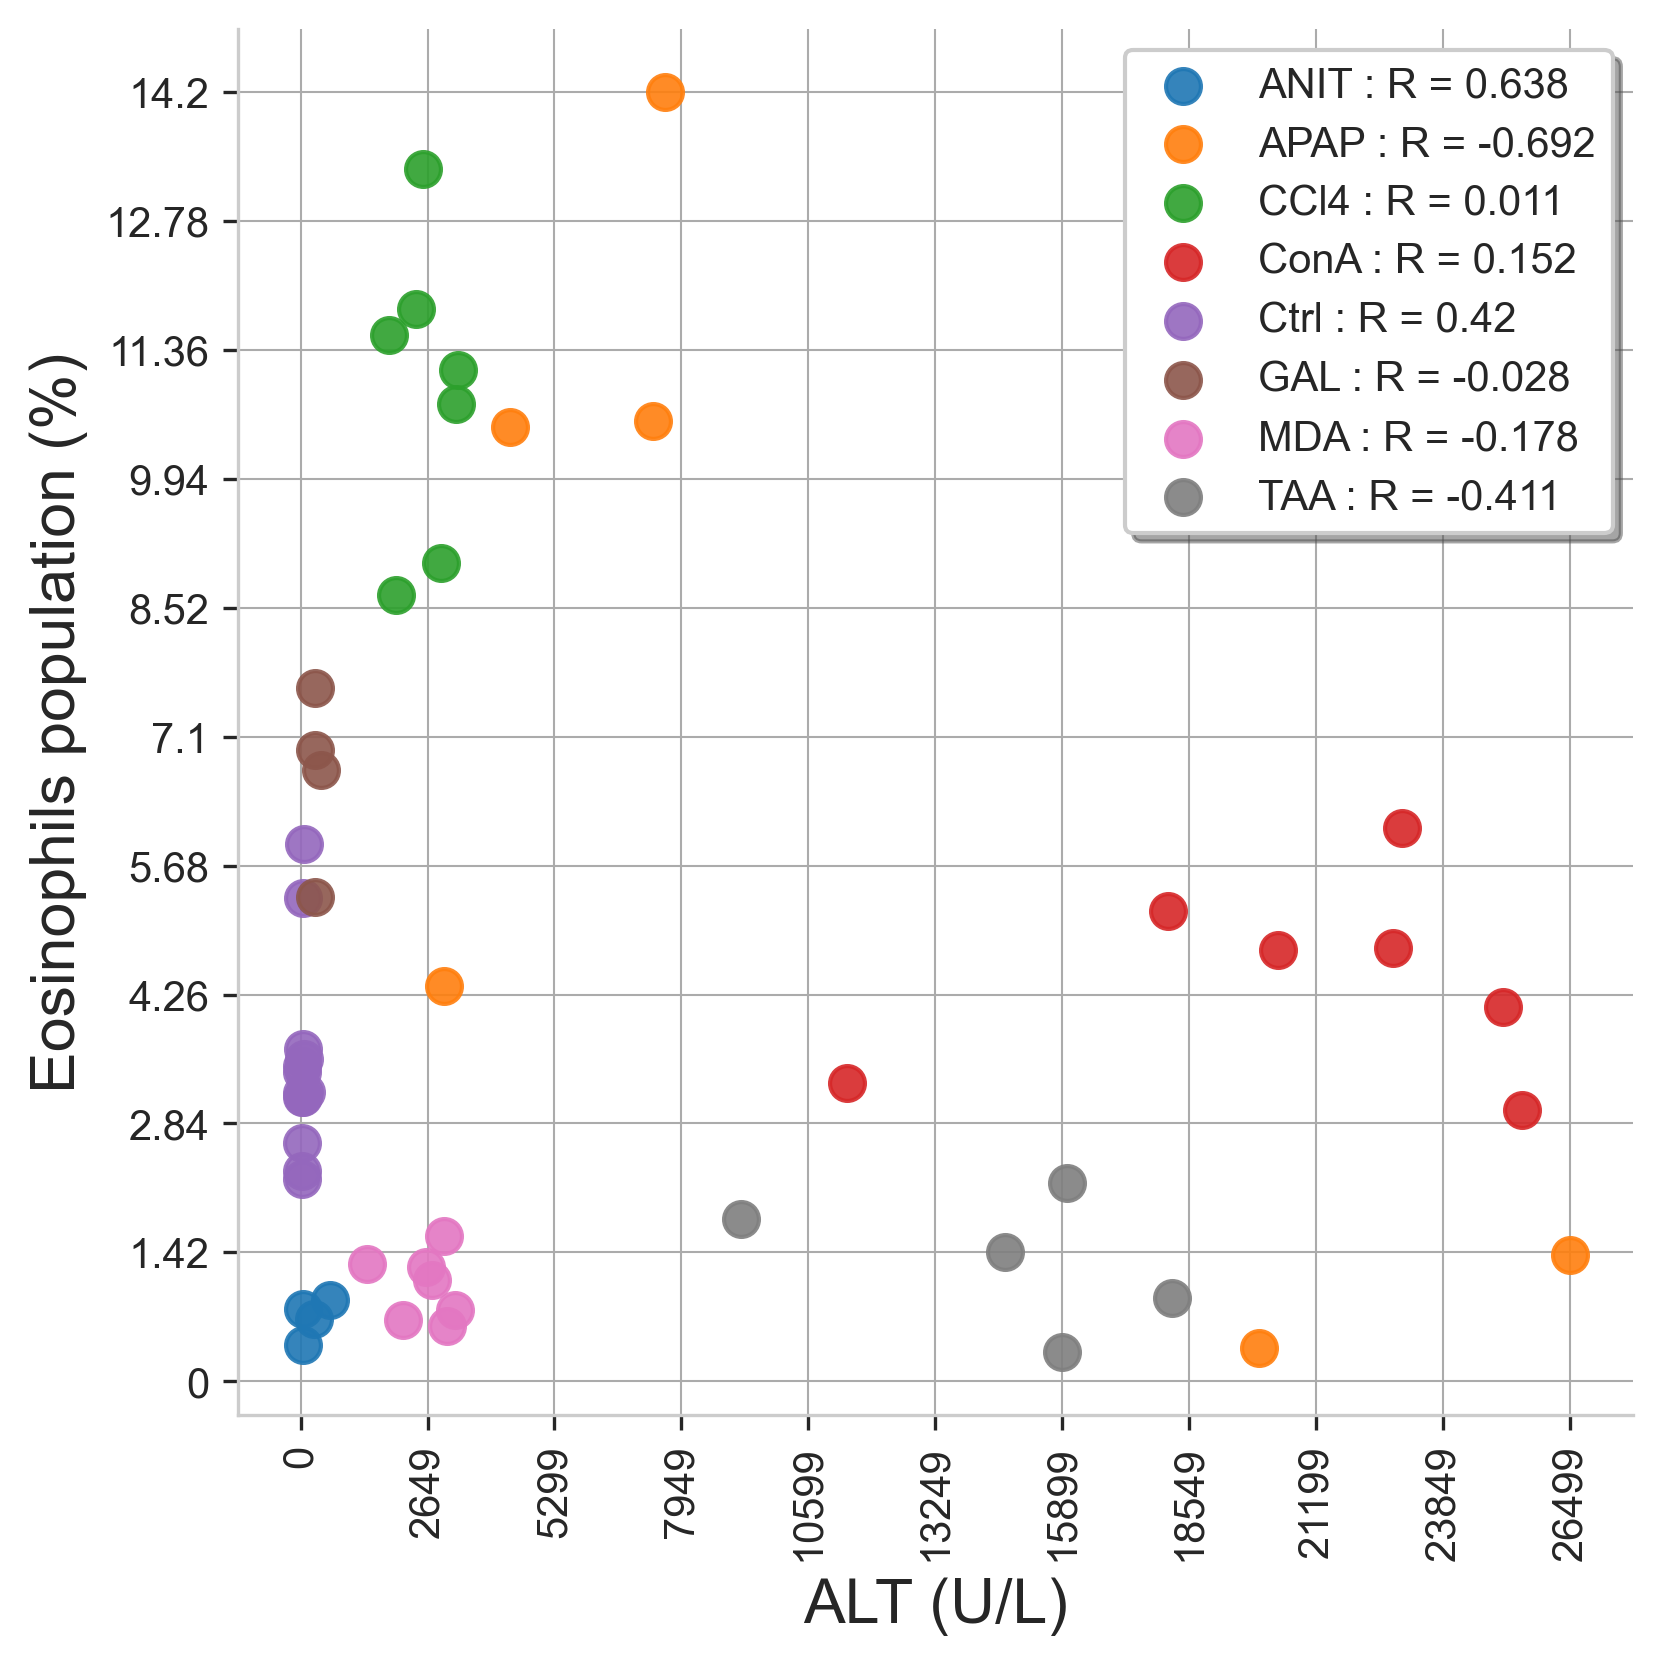

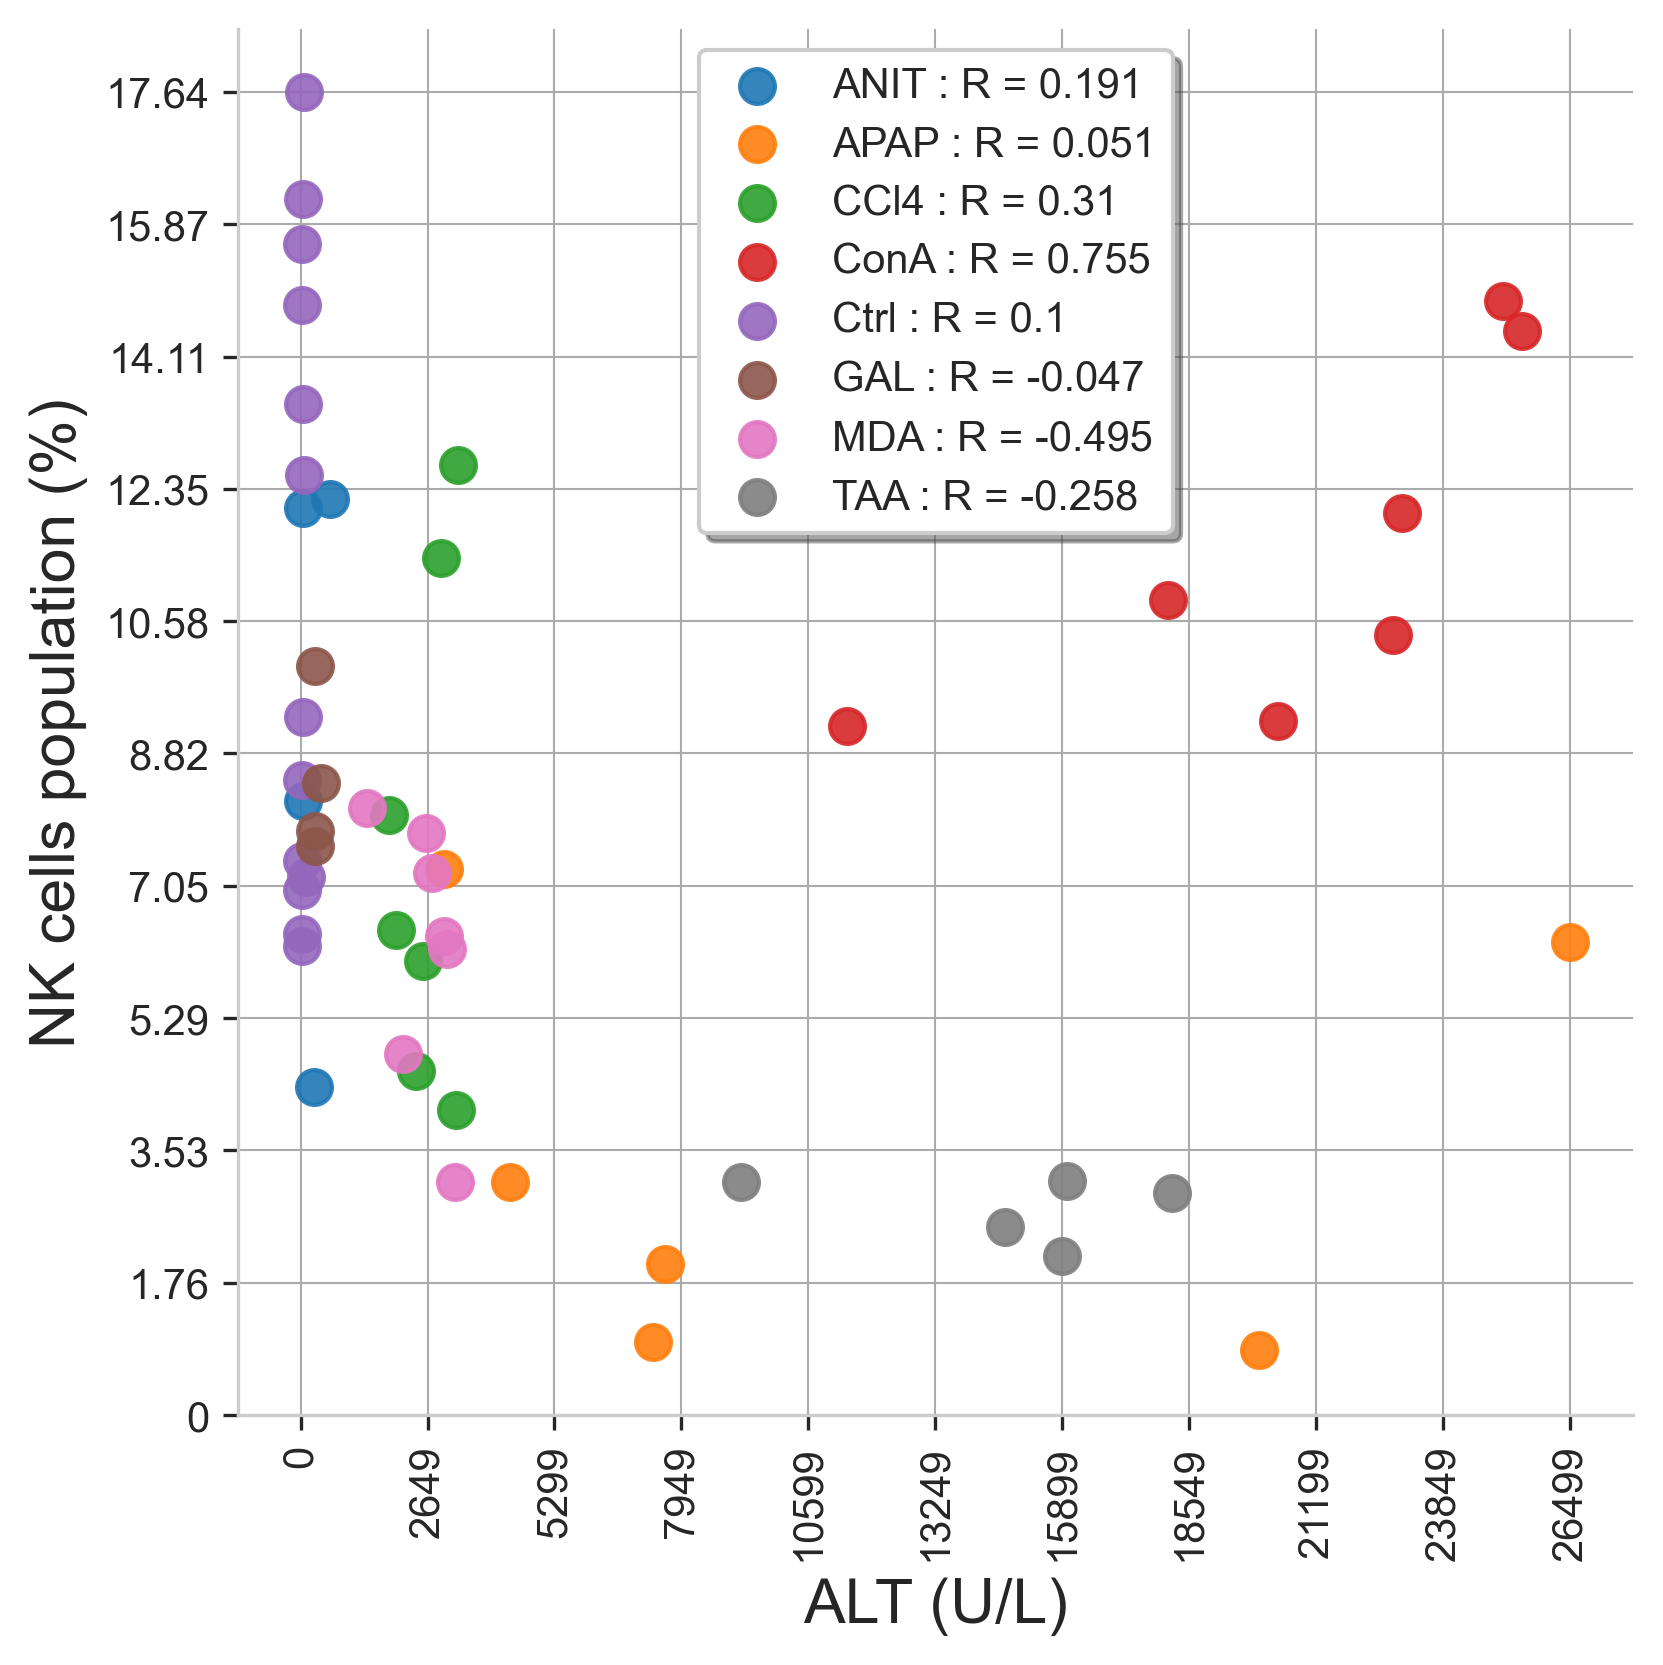

In [4]:
dpi = 300
#%% blood biochemistry and immune correlation
bb_df = pd.read_csv('C:/github/LiverDeconv/Data/input/blood_biochemistry_values.csv',index_col=0)
bb_df.index = bb_df['Name'].tolist()
bb_df = bb_df[['ALT', 'AST', 'TBIL', 'DBIL']]
facs_df = pd.read_csv('C:/github/LiverDeconv/Data/processed/facs_true_population.csv',index_col=0).T
facs_target = facs_df.loc[bb_df.index.tolist()]

def plot_value_corr(deconv_df,val_df,dec_name=["CD4","CD8"],val_name=["abT"],sort_index=[],sep=True,title=None,xname="ALT (U/L)",yname='Neutrophils population',dpi=100):
    """
    Correlation Scatter Plotting
    Format of both input dataframe is as follows
    
                 B       CD4       CD8  Monocytes        NK  Neutrophils
    AN_1 -0.327957 -0.808524 -0.768420   0.311360  0.028878     0.133660
    AN_2  0.038451 -0.880116 -0.278970  -1.039572  0.865344    -0.437588
    AN_3 -0.650633  0.574758 -0.498567  -0.796406 -0.100941     0.035709
    AN_4 -0.479019 -0.005198 -0.675028  -0.787741  0.343481    -0.062349
    AP_1 -1.107050  0.574758  0.858366  -1.503722 -1.053643     1.010999
    
    """
    if title is None:
        title = str(dec_name)+" vs "+str(val_name)
    
    if len(sort_index)>0:
        drugs = sort_index
    elif sep:
        drugs = sorted(list(set([t.split("_")[0] for t in deconv_df.index.tolist()])))
    else:
        drugs = sorted(deconv_df.index.tolist())
    
    # align the index
    val_df = val_df.loc[deconv_df.index.tolist()]
    
    dec_min = 100
    dec_max = 0
    total_x = deconv_df[dec_name].sum(axis=1).tolist()
    total_y = val_df[val_name].sum(axis=1).tolist()
    
    norm_x_max = max(total_x)
    norm_y_max = max(total_y)
    
    total_cor = round(np.corrcoef(total_x,total_y)[0][1],4)
    
    fig,ax = plt.subplots(figsize=(6,6),dpi=dpi)
    for i,d in enumerate(drugs):
        tmp1 = deconv_df.filter(regex="^"+d+"_",axis=0)
        tmp2 = val_df.filter(regex="^"+d+"_",axis=0)
        
        res1 = tmp1[dec_name].sum(axis=1).tolist()
        res1_norm = [t/norm_x_max for t in res1]
        res2 = tmp2[val_name].sum(axis=1).tolist()
        res2_norm = [t/norm_y_max for t in res2]
        tmp_cor = round(np.corrcoef(res1_norm,res2_norm)[0][1],3)
    
        plt.scatter(res1_norm,res2_norm,label=d+" : R = "+str(tmp_cor),alpha=0.9,s=70)
        
        if min(res1)<dec_min:
            dec_min = min(res1)
        if max(res1)>dec_max:
            dec_max = max(res1)
    
    #plt.plot([dec_min,dec_max],[dec_min,dec_max],linewidth=2,color='black',linestyle='dashed',zorder=-1)
    
    #plt.text(0.3,0.05,'Cor = {}'.format(str(round(total_cor,3))), transform=ax.transAxes, fontsize=15)
    
    plt.legend(shadow=True)
    plt.xticks([0]+[0.1*i for i in range(1,11)],[str(0)]+[str(int(0.1*i*norm_x_max)) for i in range(1,11)],rotation=90)
    plt.yticks([0]+[0.1*i for i in range(1,11)],[str(0)]+[str(round(10*i*norm_y_max,2)) for i in range(1,11)])
    plt.xlabel(xname,fontsize=15)
    plt.ylabel(yname,fontsize=15)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')
    ax.set_axisbelow(True)
    ax.grid(color="#ababab",linewidth=0.5)
    plt.title(title,fontsize=15)
    plt.show()

    return 

plot_value_corr(deconv_df=bb_df, val_df=facs_target, dec_name=["ALT"],val_name=["Neutrophil"],sort_index=[],xname="ALT (U/L)",yname='Neutrophils population (%)',sep=True,title="",dpi=dpi)
plot_value_corr(deconv_df=bb_df, val_df=facs_target, dec_name=["ALT"],val_name=["Monocyte"],sort_index=[],xname="ALT (U/L)",yname='Monocytes population (%)',sep=True,title="",dpi=dpi)
plot_value_corr(deconv_df=bb_df, val_df=facs_target, dec_name=["ALT"],val_name=["Eosinophil"],sort_index=[],xname="ALT (U/L)",yname='Eosinophils population (%)',sep=True,title="",dpi=dpi)
plot_value_corr(deconv_df=bb_df, val_df=facs_target, dec_name=["ALT"],val_name=["NK"],sort_index=[],xname="ALT (U/L)",yname='NK cells population (%)',sep=True,title="",dpi=dpi)

***
##### ConA and APAP administration groups

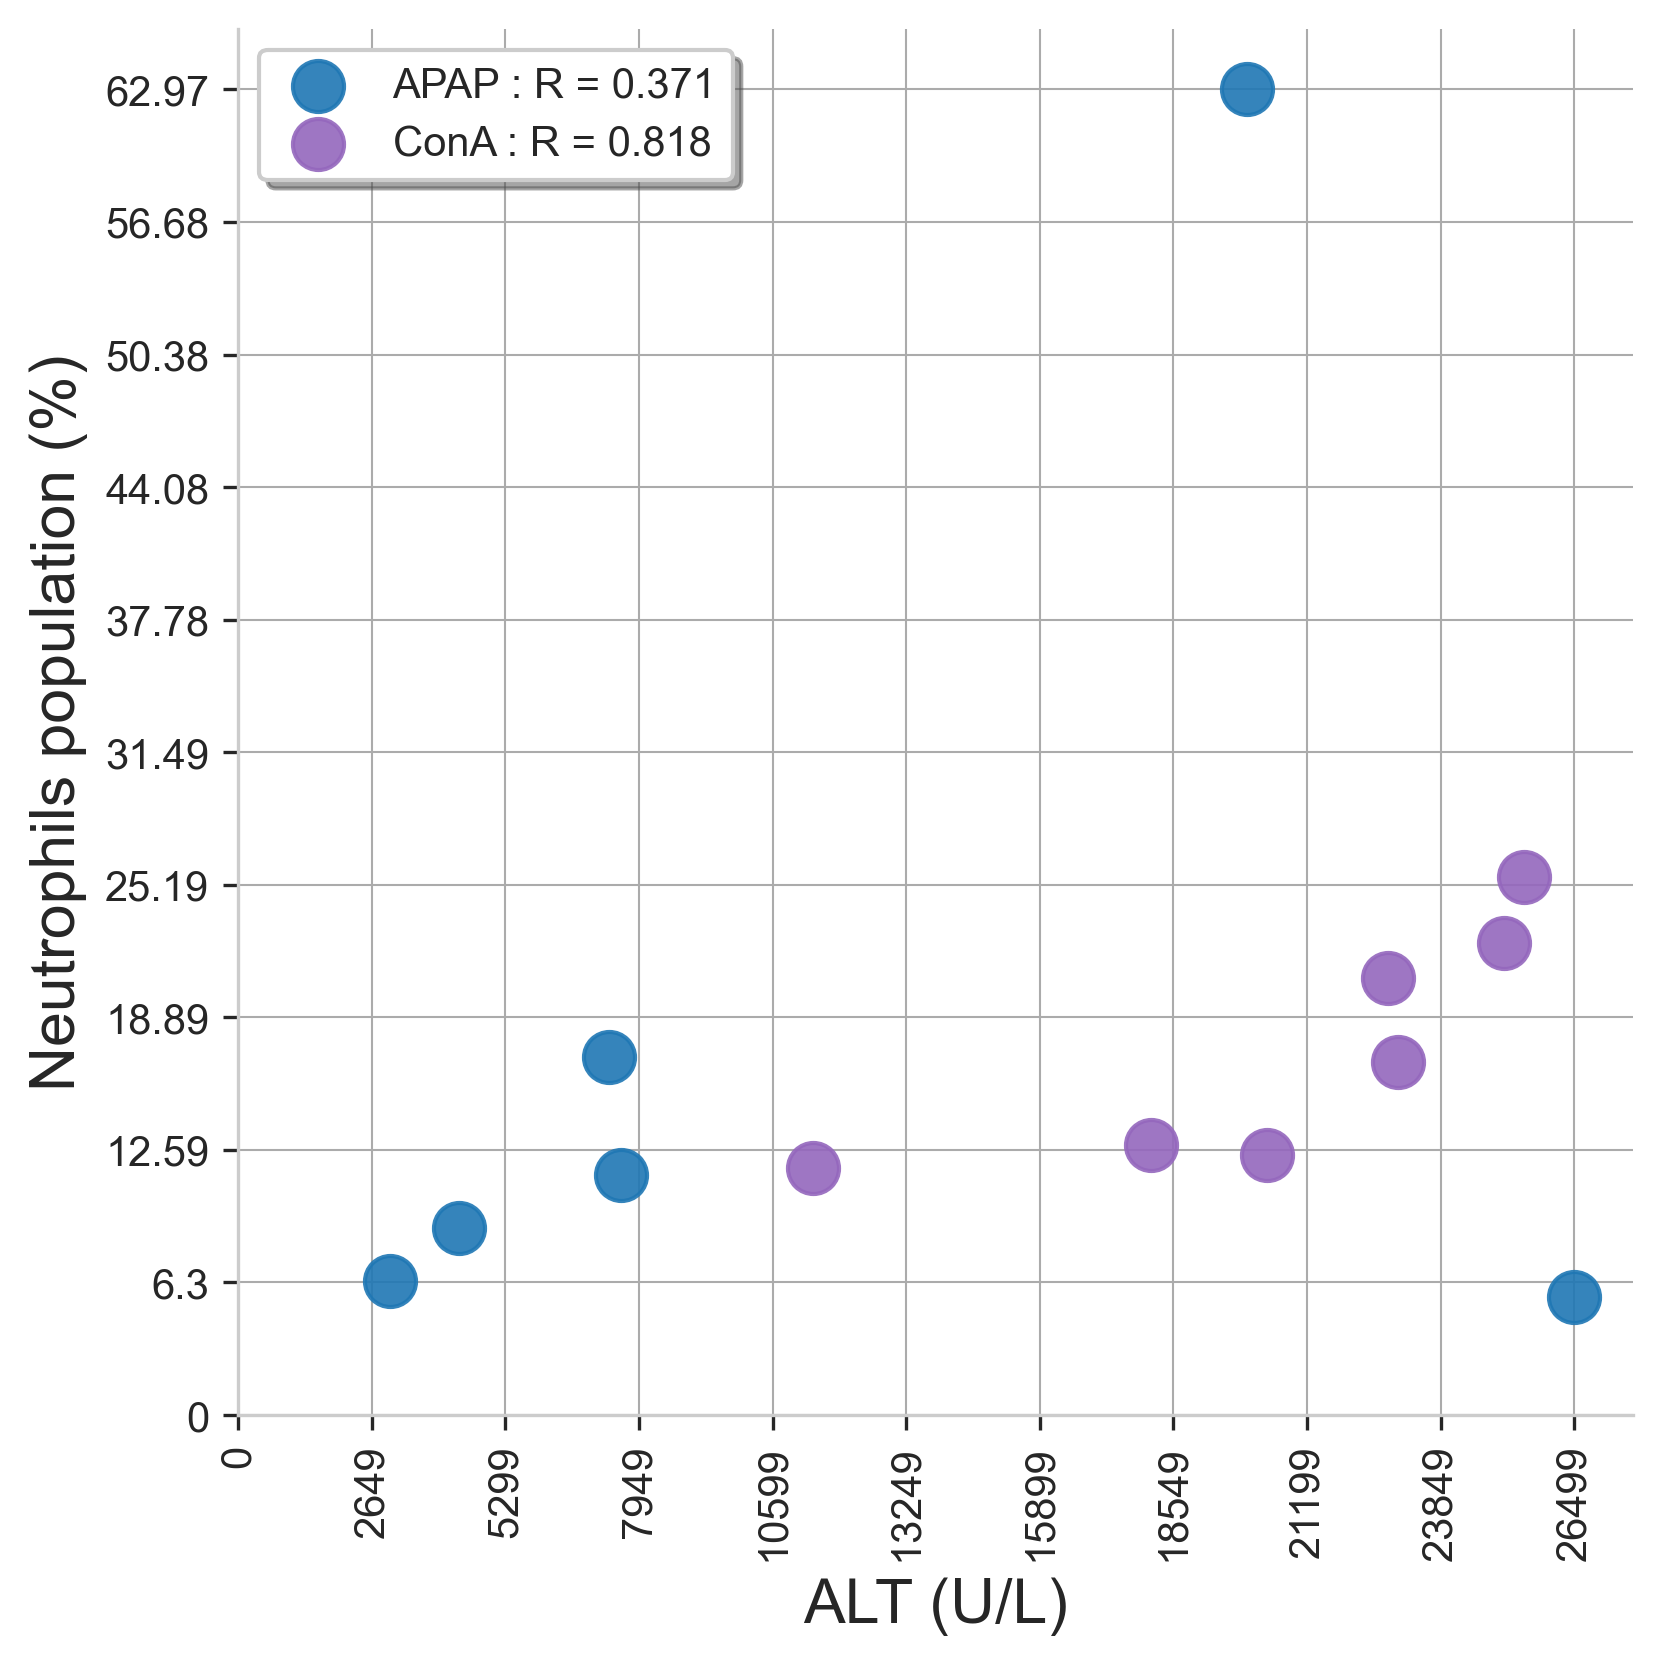

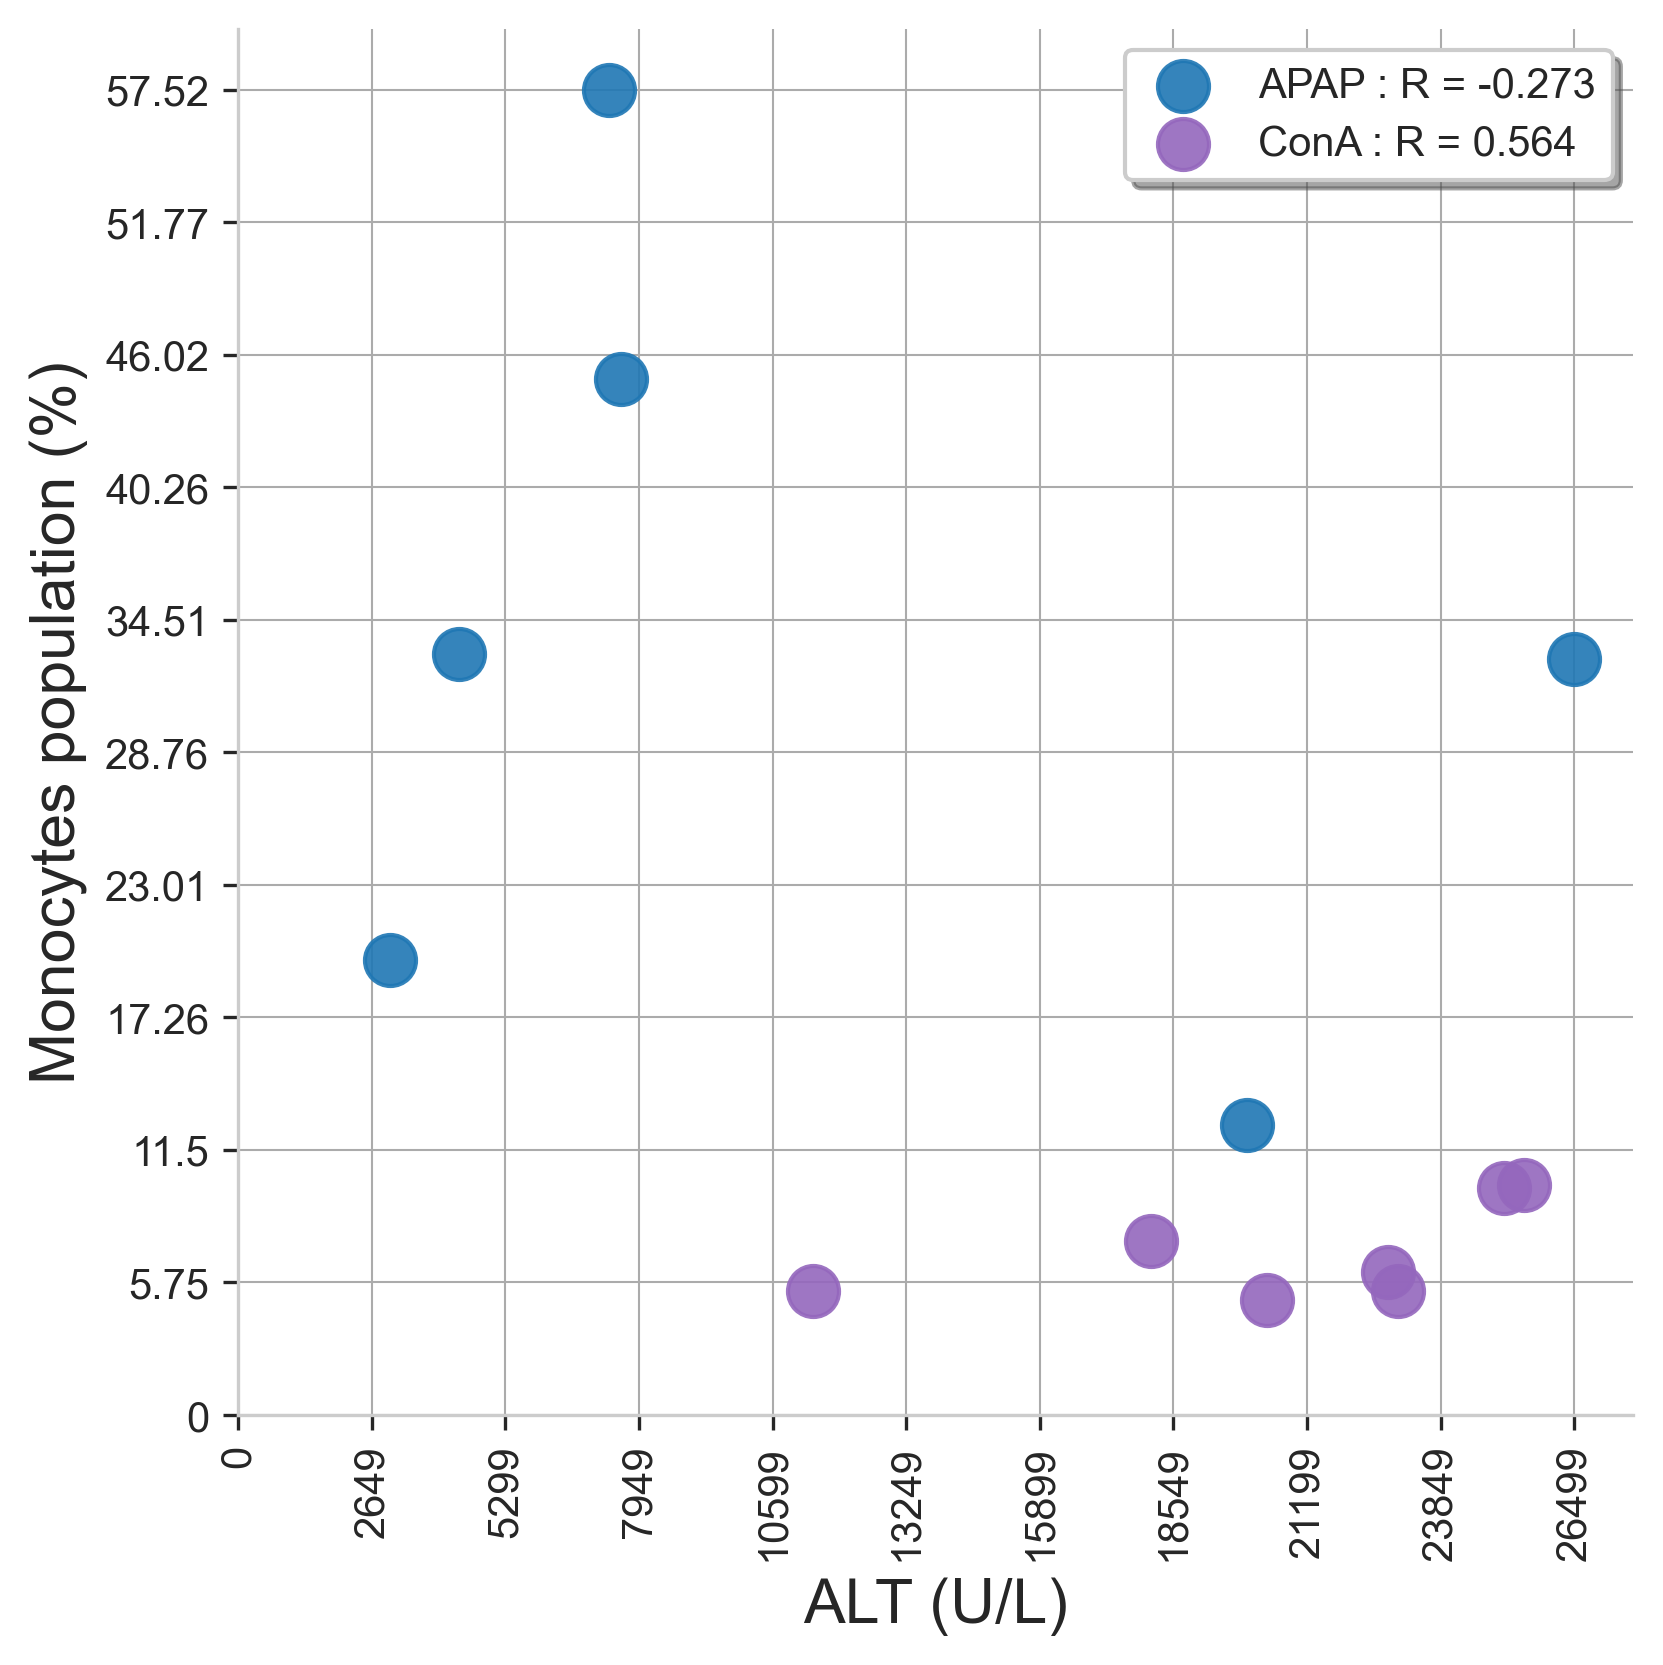

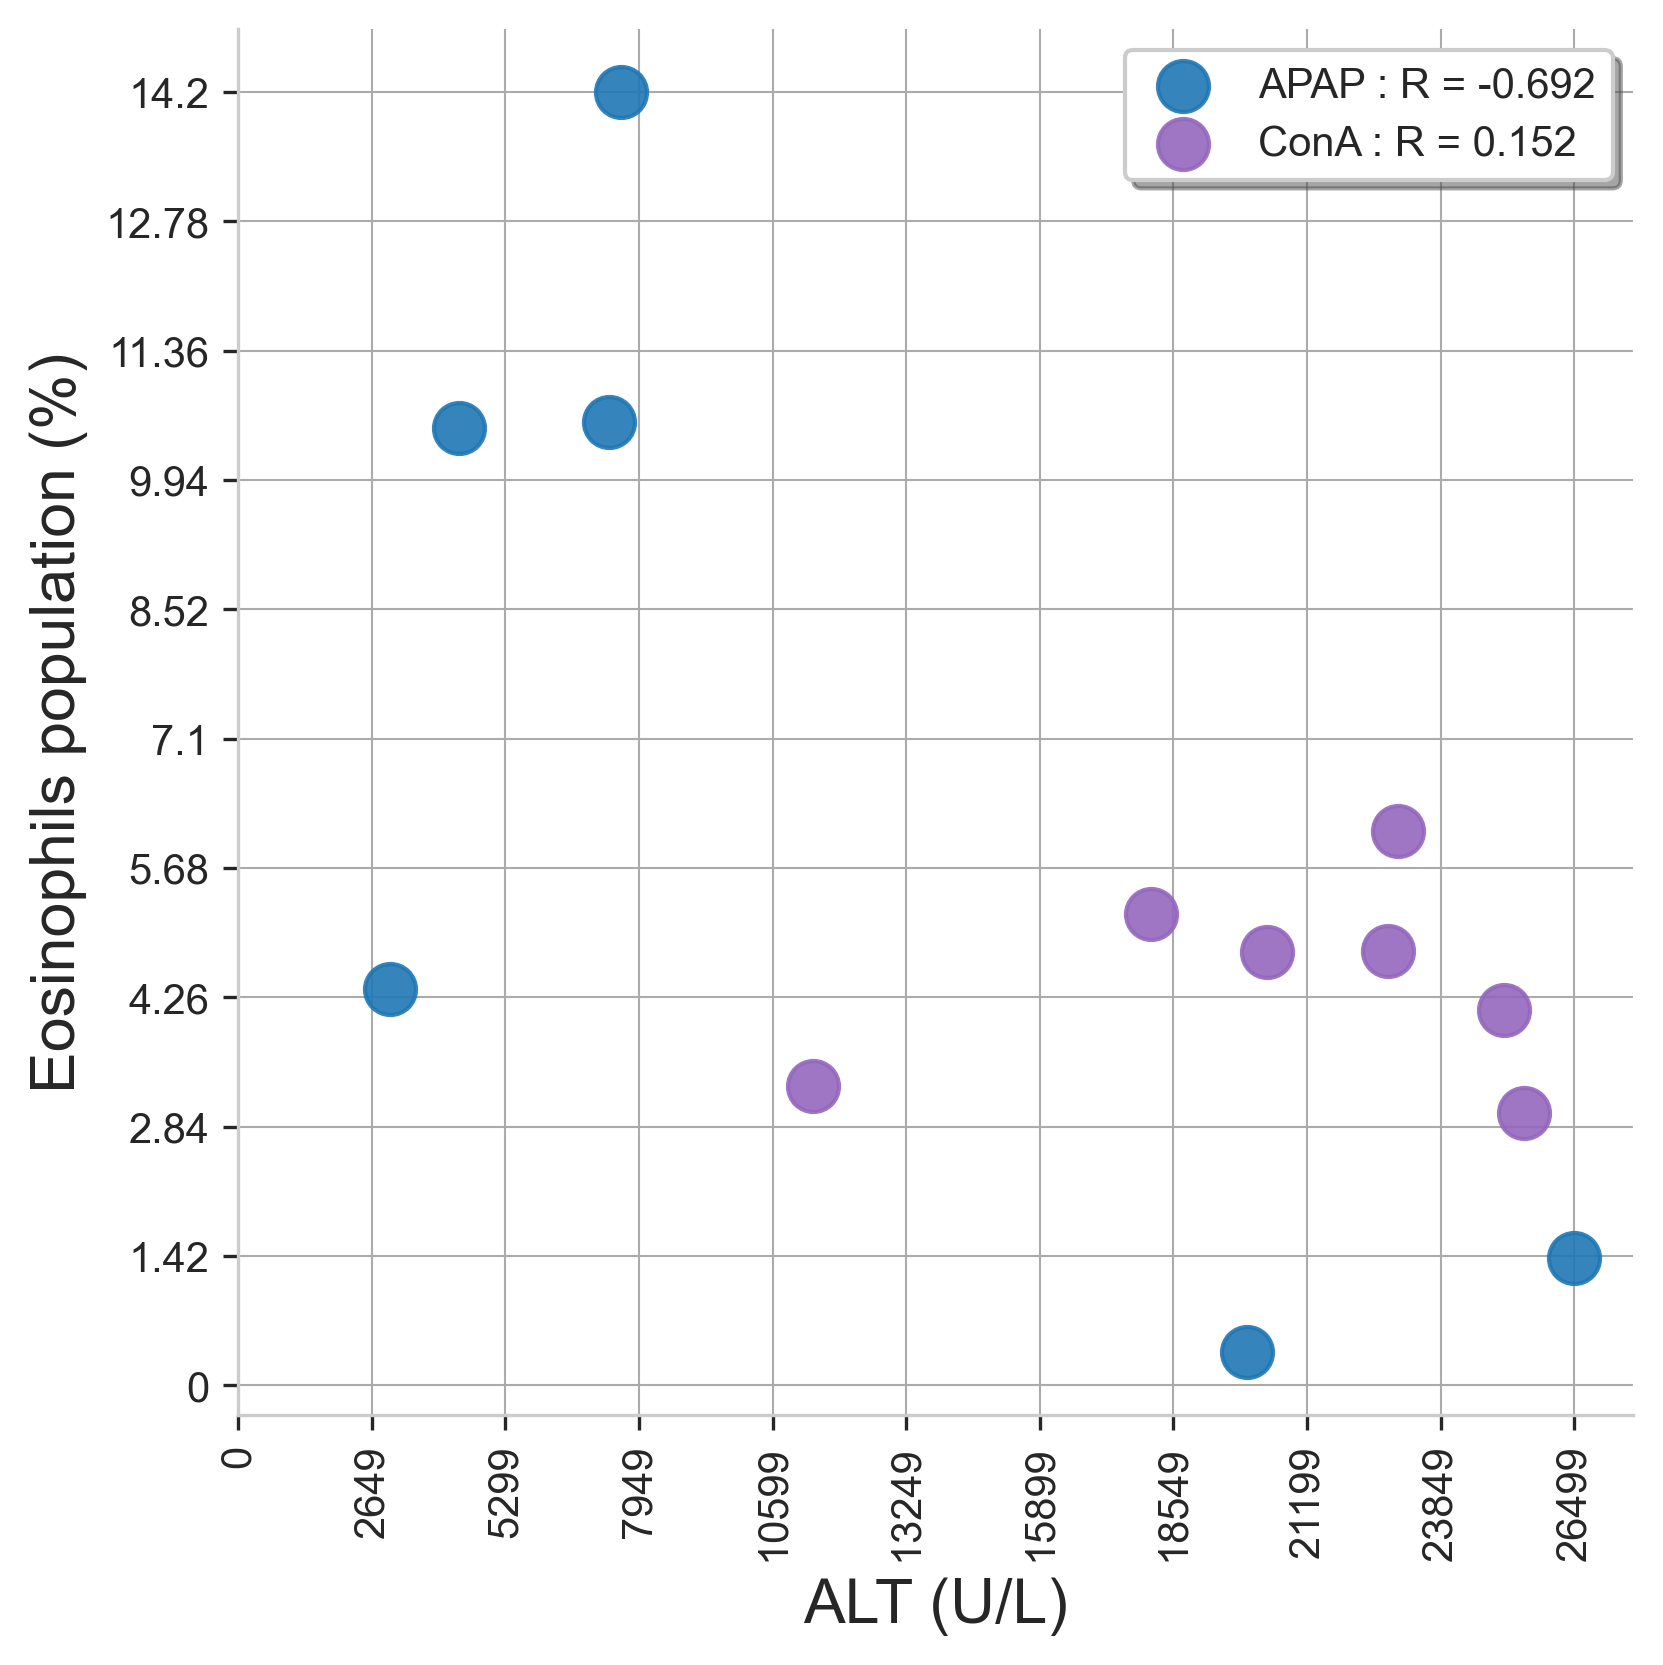

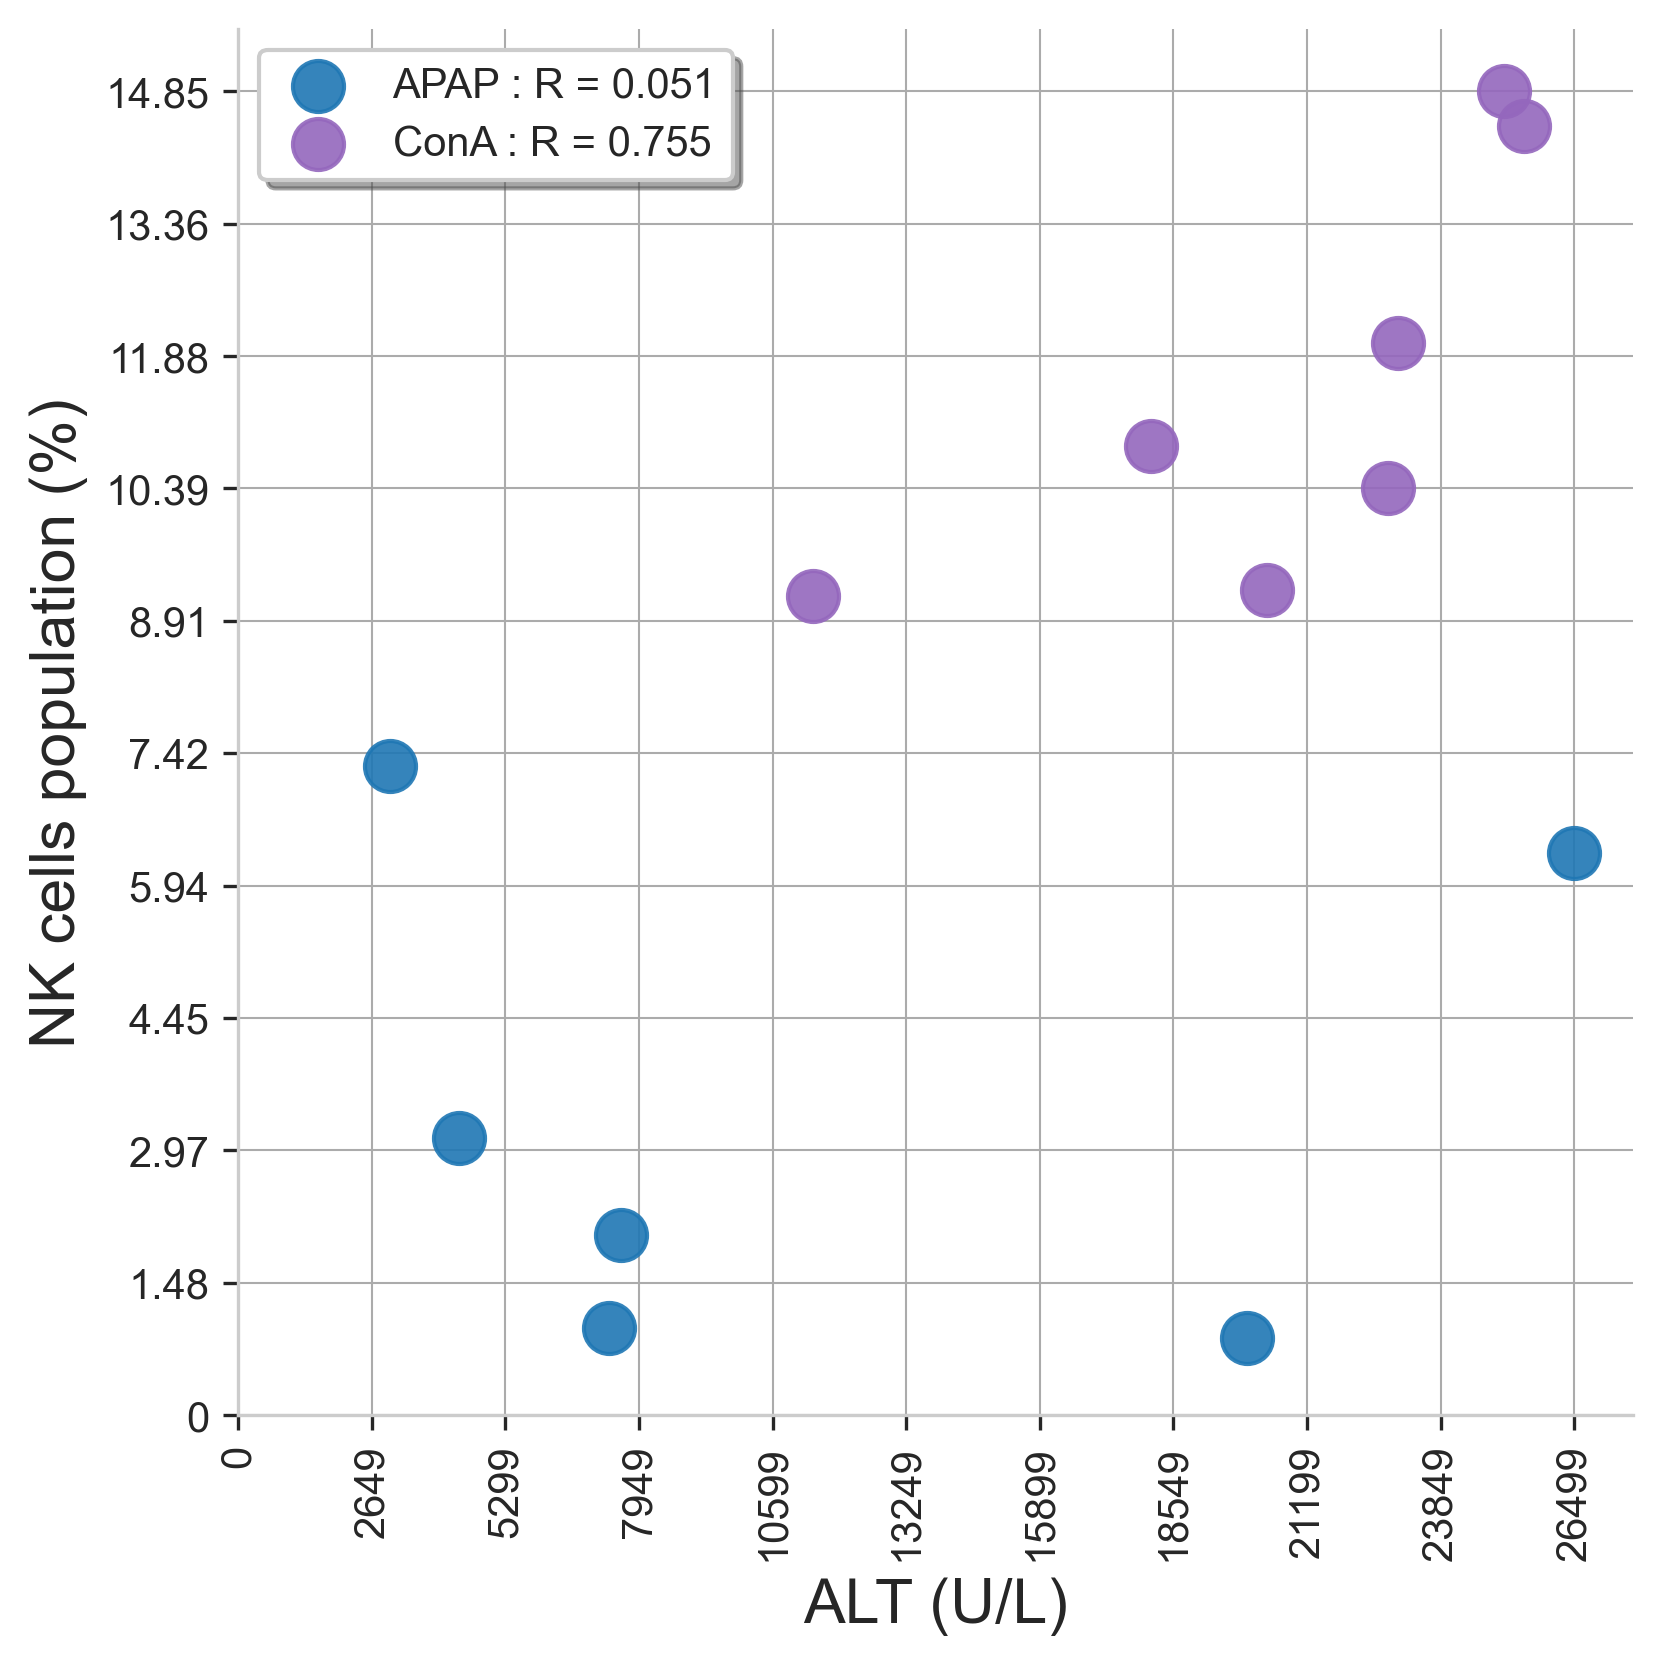

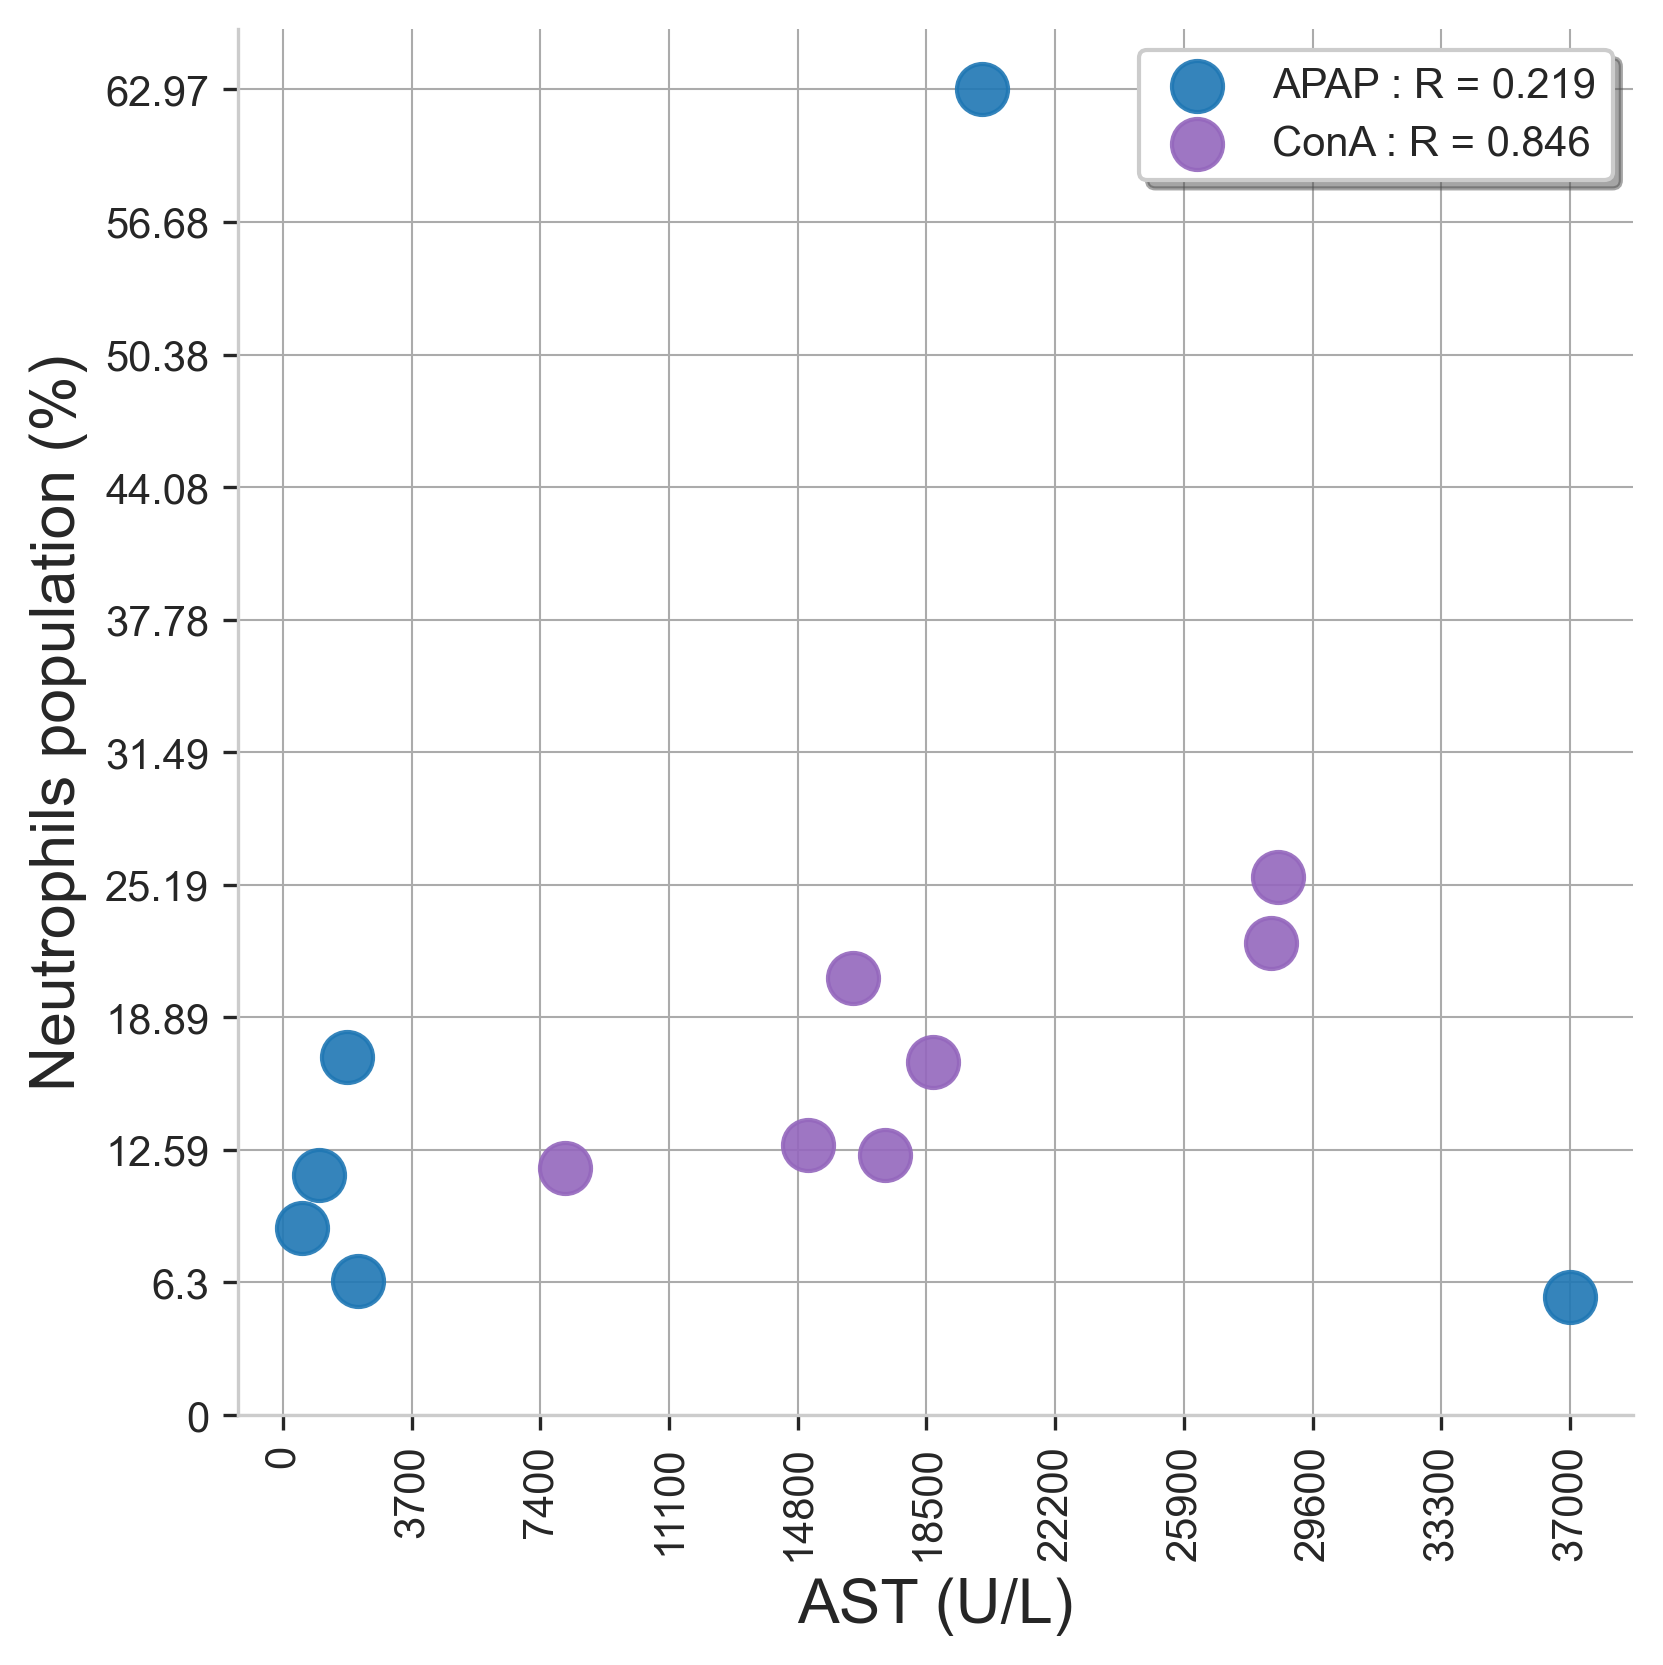

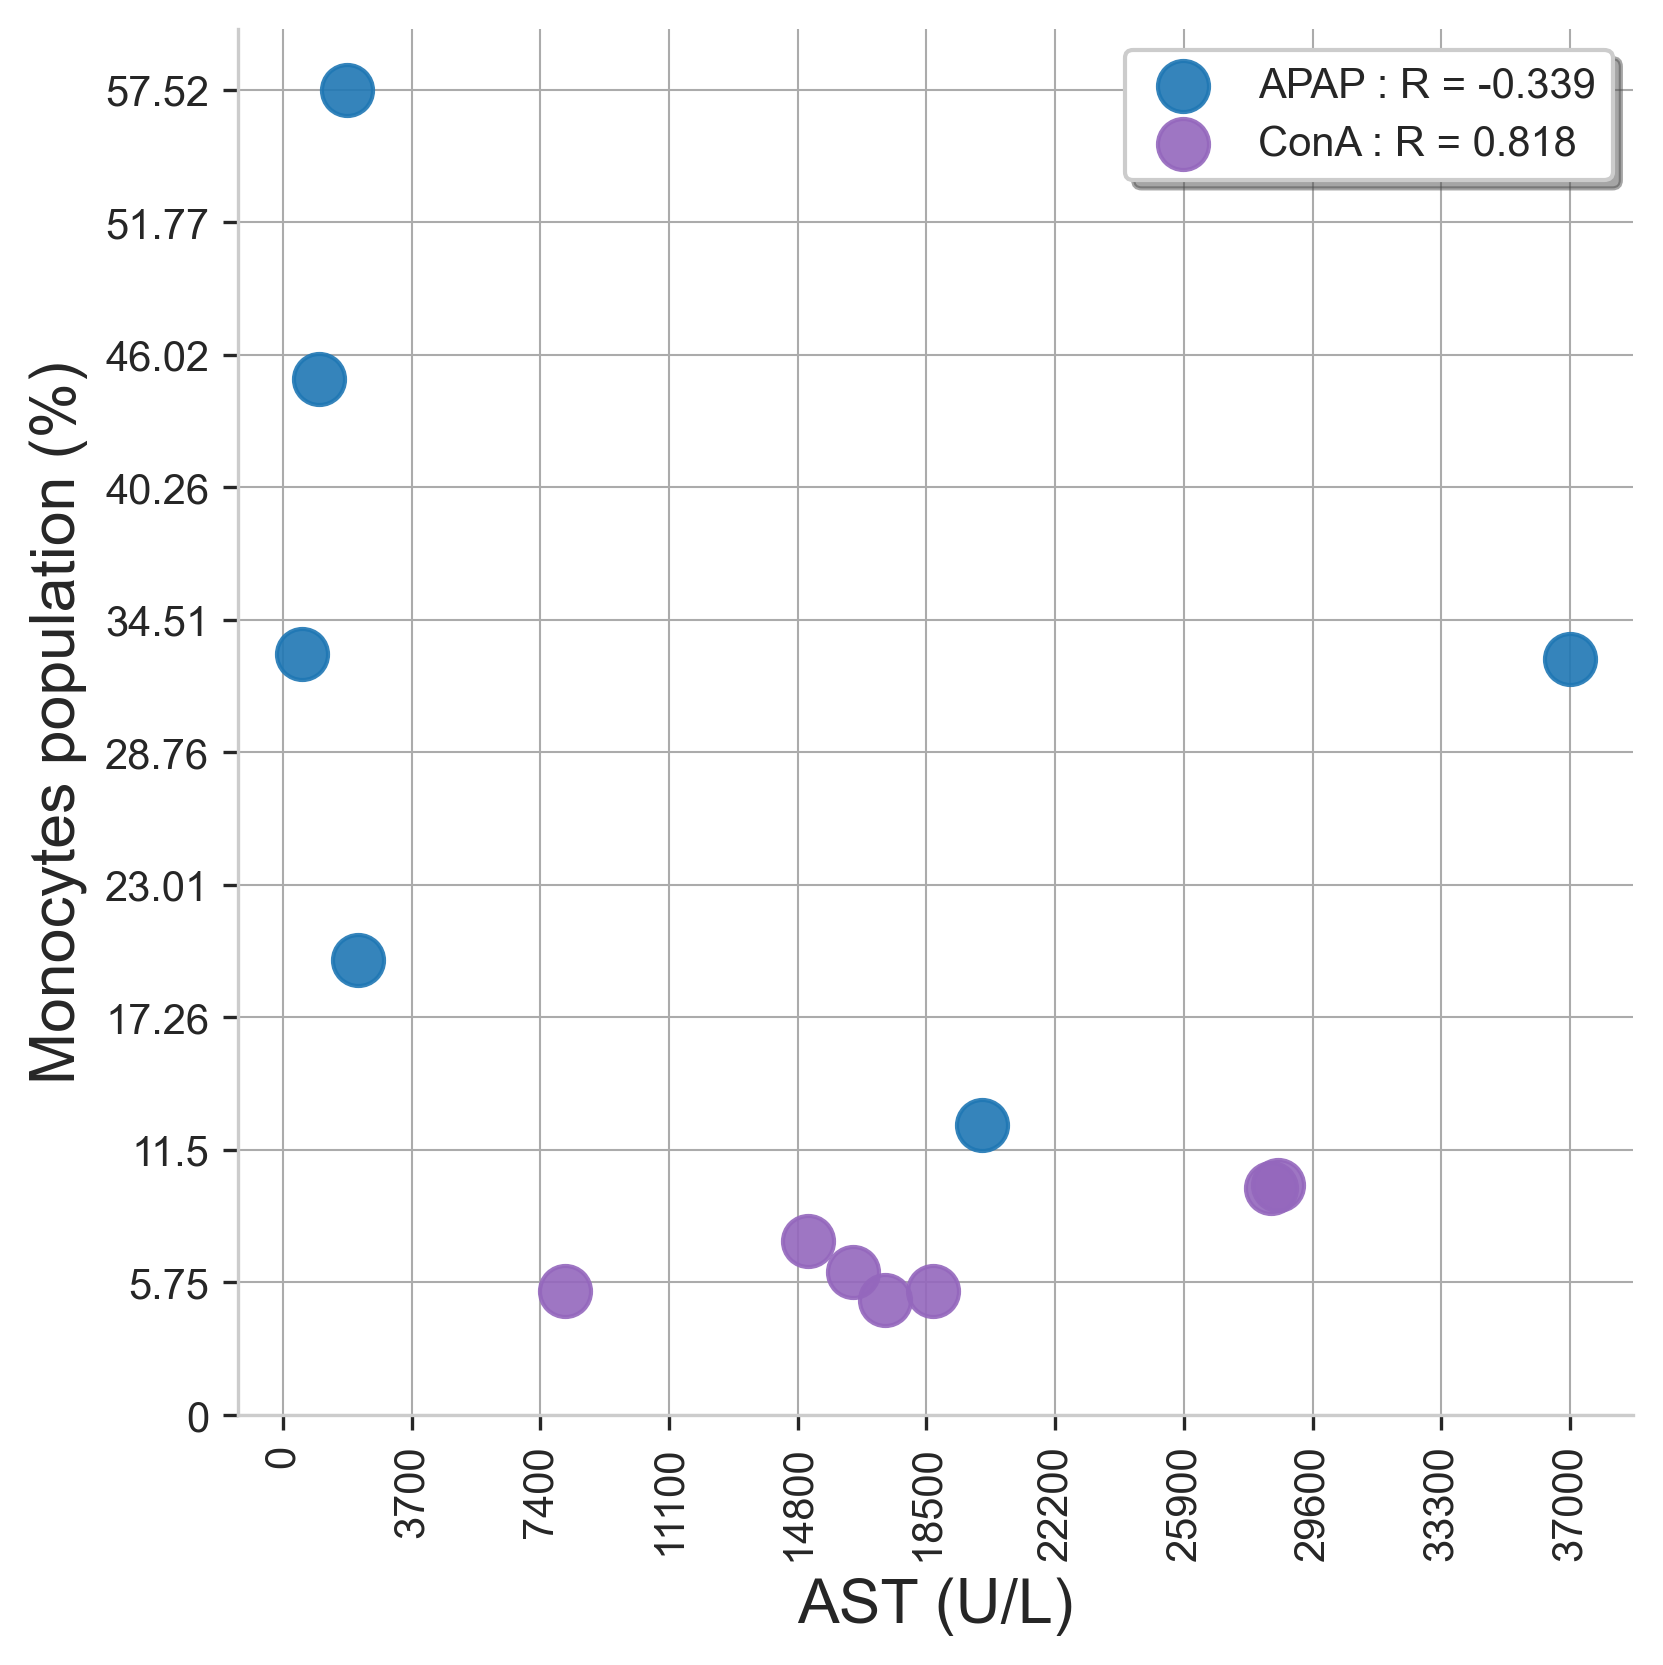

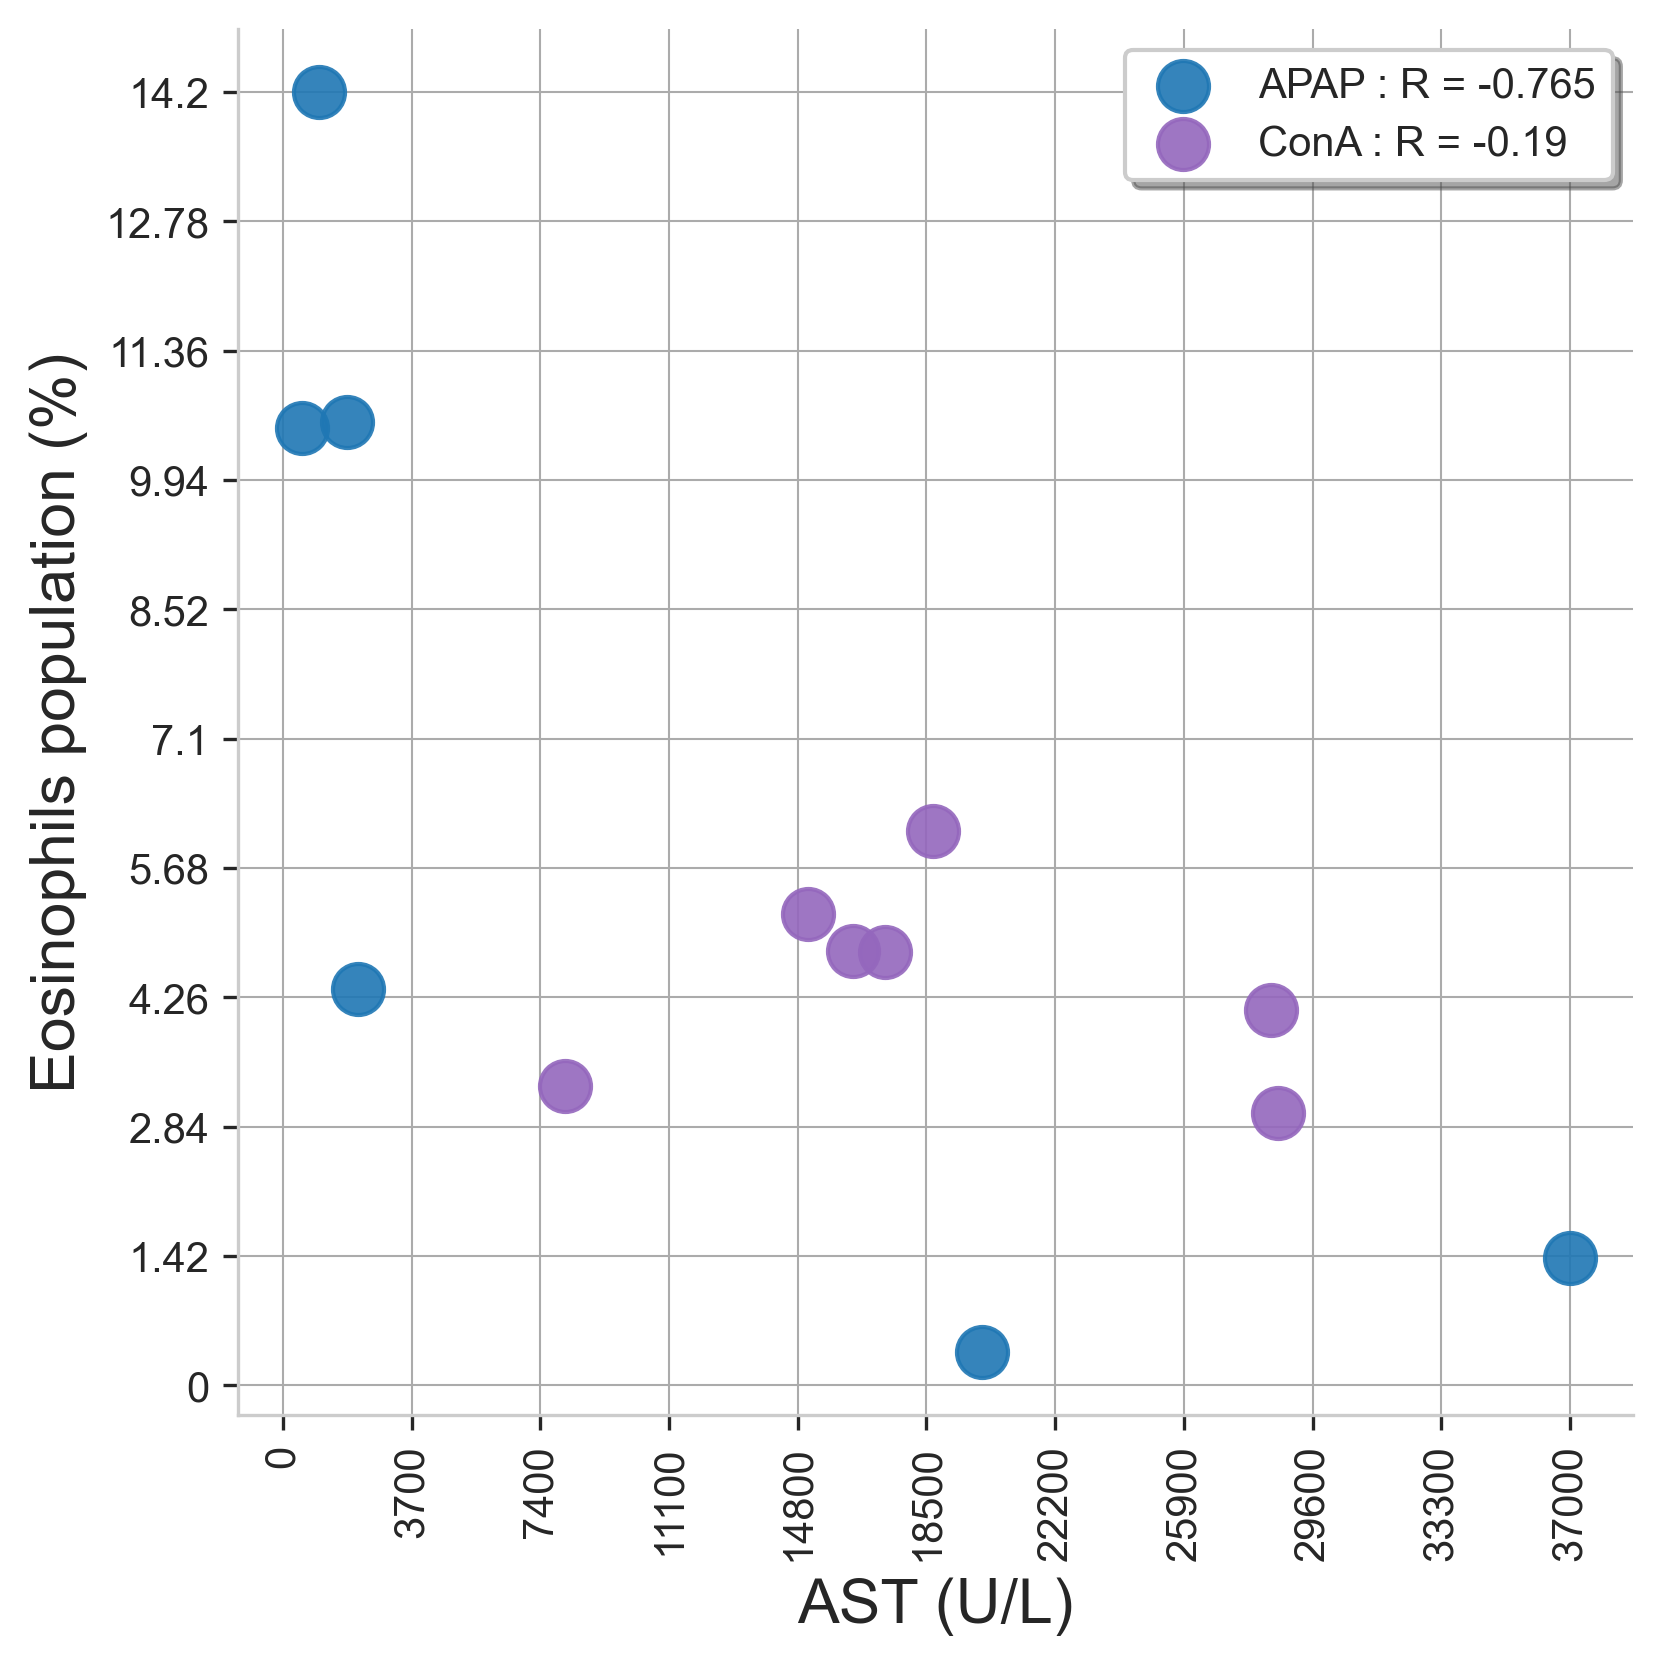

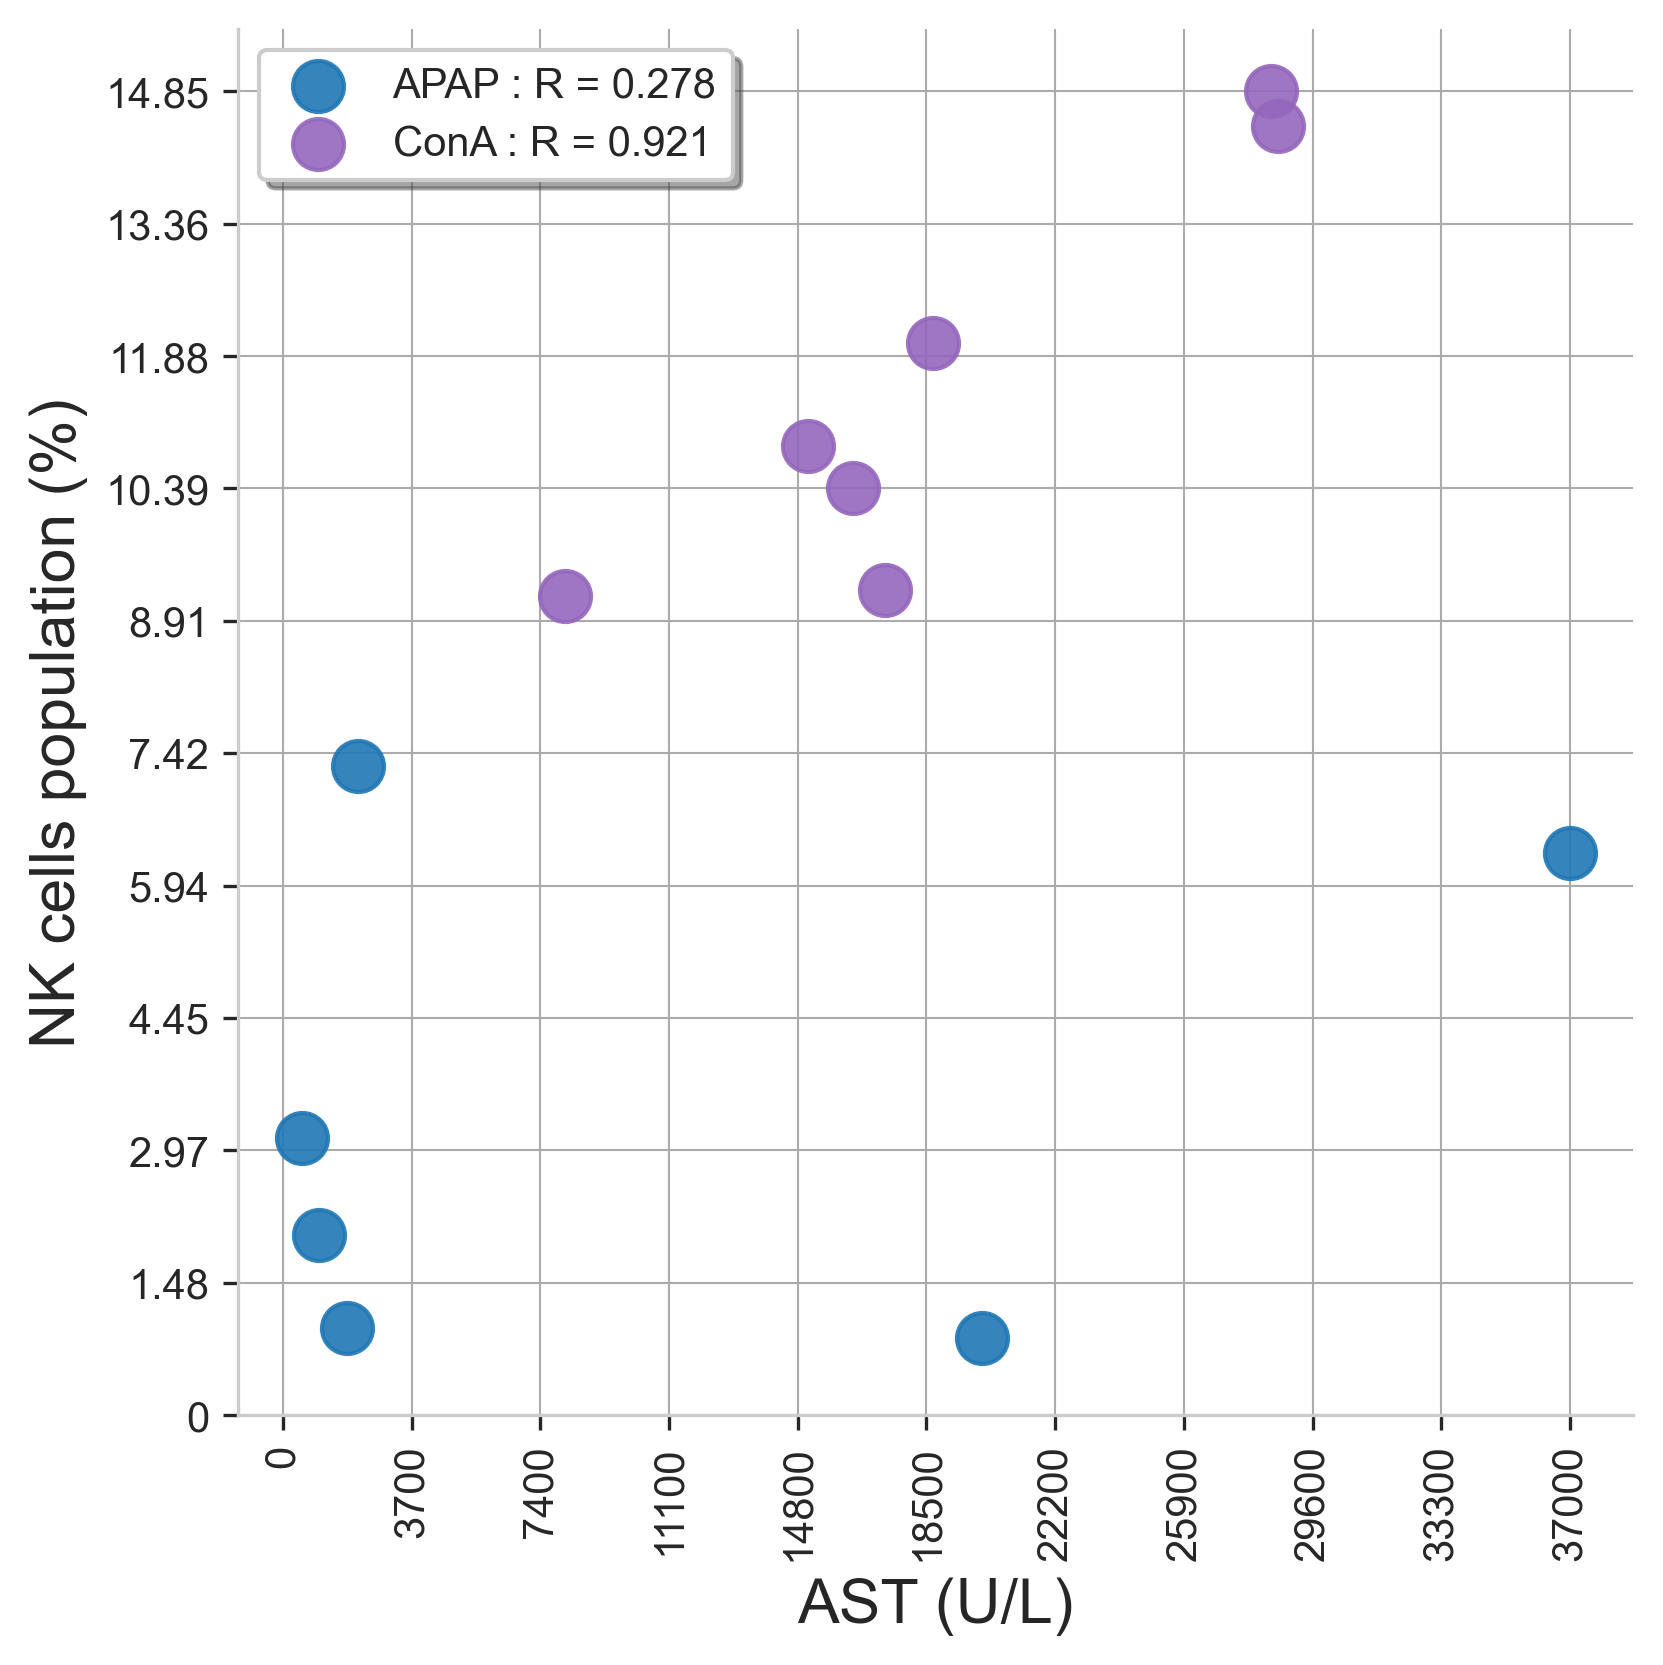

In [5]:
dpi = 300
#%% ConA and APAP (large variance)
bb_df = pd.read_csv('C:/github/LiverDeconv/Data/input/blood_biochemistry_values.csv',index_col=0)
bb_df.index = bb_df['Name'].tolist()
bb_df = bb_df[bb_df['Treatment'].isin(['APAP','ConA'])]
bb_df = bb_df[['ALT', 'AST', 'TBIL', 'DBIL']]
facs_df = pd.read_csv('C:/github/LiverDeconv/Data/processed/facs_true_population.csv',index_col=0).T
facs_target = facs_df.loc[bb_df.index.tolist()]

def plot_value_corr(deconv_df,val_df,dec_name=["CD4","CD8"],val_name=["abT"],sort_index=[],sep=True,title=None,xname="ALT (U/L)",yname='Neutrophils population',dpi=300):
    """
    Correlation Scatter Plotting
    Format of both input dataframe is as follows
    
                 B       CD4       CD8  Monocytes        NK  Neutrophils
    AN_1 -0.327957 -0.808524 -0.768420   0.311360  0.028878     0.133660
    AN_2  0.038451 -0.880116 -0.278970  -1.039572  0.865344    -0.437588
    AN_3 -0.650633  0.574758 -0.498567  -0.796406 -0.100941     0.035709
    AN_4 -0.479019 -0.005198 -0.675028  -0.787741  0.343481    -0.062349
    AP_1 -1.107050  0.574758  0.858366  -1.503722 -1.053643     1.010999
    
    """
    if title is None:
        title = str(dec_name)+" vs "+str(val_name)
    
    if len(sort_index)>0:
        drugs = sort_index
    elif sep:
        drugs = sorted(list(set([t.split("_")[0] for t in deconv_df.index.tolist()])))
    else:
        drugs = sorted(deconv_df.index.tolist())
    
    # align the index
    val_df = val_df.loc[deconv_df.index.tolist()]
    
    dec_min = 100
    dec_max = 0
    total_x = deconv_df[dec_name].sum(axis=1).tolist()
    total_y = val_df[val_name].sum(axis=1).tolist()
    
    norm_x_max = max(total_x)
    norm_y_max = max(total_y)
    
    total_cor = round(np.corrcoef(total_x,total_y)[0][1],4)
    
    color_list = ['tab:blue','tab:purple']
    fig,ax = plt.subplots(figsize=(6,6),dpi=dpi)
    for i,d in enumerate(drugs):
        tmp1 = deconv_df.filter(regex="^"+d+"_",axis=0)
        tmp2 = val_df.filter(regex="^"+d+"_",axis=0)
        
        res1 = tmp1[dec_name].sum(axis=1).tolist()
        res1_norm = [t/norm_x_max for t in res1]
        res2 = tmp2[val_name].sum(axis=1).tolist()
        res2_norm = [t/norm_y_max for t in res2]
        tmp_cor = round(np.corrcoef(res1_norm,res2_norm)[0][1],3)
    
        plt.scatter(res1_norm,res2_norm,label=d+" : R = "+str(tmp_cor),alpha=0.9,s=150,c=color_list[i])
        
        if min(res1)<dec_min:
            dec_min = min(res1)
        if max(res1)>dec_max:
            dec_max = max(res1)
    
    #plt.plot([dec_min,dec_max],[dec_min,dec_max],linewidth=2,color='black',linestyle='dashed',zorder=-1)
    
    #plt.text(0.3,0.05,'Cor = {}'.format(str(round(total_cor,3))), transform=ax.transAxes, fontsize=15)
    
    plt.legend(shadow=True)
    plt.xticks([0]+[0.1*i for i in range(1,11)],[str(0)]+[str(int(0.1*i*norm_x_max)) for i in range(1,11)],rotation=90)
    plt.yticks([0]+[0.1*i for i in range(1,11)],[str(0)]+[str(round(10*i*norm_y_max,2)) for i in range(1,11)])
    plt.xlabel(xname,fontsize=15)
    plt.ylabel(yname,fontsize=15)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')
    ax.set_axisbelow(True)
    ax.grid(color="#ababab",linewidth=0.5)
    plt.title(title,fontsize=15)
    plt.show()

    return

plot_value_corr(deconv_df=bb_df, val_df=facs_target, dec_name=["ALT"],val_name=["Neutrophil"],sort_index=[],xname="ALT (U/L)",yname='Neutrophils population (%)',sep=True,title="",dpi=dpi)
plot_value_corr(deconv_df=bb_df, val_df=facs_target, dec_name=["ALT"],val_name=["Monocyte"],sort_index=[],xname="ALT (U/L)",yname='Monocytes population (%)',sep=True,title="",dpi=dpi)
plot_value_corr(deconv_df=bb_df, val_df=facs_target, dec_name=["ALT"],val_name=["Eosinophil"],sort_index=[],xname="ALT (U/L)",yname='Eosinophils population (%)',sep=True,title="",dpi=dpi)
plot_value_corr(deconv_df=bb_df, val_df=facs_target, dec_name=["ALT"],val_name=["NK"],sort_index=[],xname="ALT (U/L)",yname='NK cells population (%)',sep=True,title="",dpi=dpi)

plot_value_corr(deconv_df=bb_df, val_df=facs_target, dec_name=["AST"],val_name=["Neutrophil"],sort_index=[],xname="AST (U/L)",yname='Neutrophils population (%)',sep=True,title="",dpi=dpi)
plot_value_corr(deconv_df=bb_df, val_df=facs_target, dec_name=["AST"],val_name=["Monocyte"],sort_index=[],xname="AST (U/L)",yname='Monocytes population (%)',sep=True,title="",dpi=dpi)
plot_value_corr(deconv_df=bb_df, val_df=facs_target, dec_name=["AST"],val_name=["Eosinophil"],sort_index=[],xname="AST (U/L)",yname='Eosinophils population (%)',sep=True,title="",dpi=dpi)
plot_value_corr(deconv_df=bb_df, val_df=facs_target, dec_name=["AST"],val_name=["NK"],sort_index=[],xname="AST (U/L)",yname='NK cells population (%)',sep=True,title="",dpi=dpi)
